# Capstone project: Pedicting HDB Prices

#### Objectives/ Problem Statement
To predict the price of new HDB launch before the launch <br>
_**Input a set of features and output a price **_

#### why this problem?
A practical problem that most Singaporeans (including myself) face 

## Part3_ Modelling_Round1b
- Using Resale data
- y variable is the variance (take away the mean) 
- X data from  1990 onwards
- train set: 1990 to 2014
- test set : 2014 to 2018

**[Iteration 1: ](#iter1)** [SLR](#1slr)  ||  [MLR by category](#1mlrcat) <br> 
X = resale data <br>
y = resale['var_resale_price'] <br>

**[Iteration 2: ](#iter2)** [SLR](#2slr)  ||  [MLR by category](#2mlrcat) <br>
X = resale data <br>
y = resale['var_adj_price'] <br>


**[Iteration 3](#iter3)** <br>
X = resale data without time data<br>
y = resale['var_resale_price'] <br>
**[Iter3a - no yr:       ](#iter3a)**[MLR all](#3amlrall) || [ridge,lasso,enet](#3aregularization) <br>
**[Iter3b - no yr&month: ](#iter3b)**:[MLR all](#3bmlrall) || [ridge,lasso,enet](#3bregularization)

**[Iteration 4](#iter4)** <br>
X = resale data without time data<br>
y = resale['var_adj_price'] <br>
**[Iter4a - no yr:       ](#iter4a)**[MLR all](#4amlrall) || [ridge,lasso,enet](#4aregularization) <br>
**[Iter4b - no yr&month: ](#iter4b)**:[MLR all](#4bmlrall) || [ridge,lasso,enet](#4bregularization)

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
import re

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Quick Cleaning 
(code and analysis taken from Part2_EDA)

In [2]:
resale = pd.read_csv('./datasets/resale_all.csv')
resale.drop([u'Unnamed: 0',u'geo_data',u'full_address','new full_address'],axis = 1,inplace=True)

#time
resale['date'] = pd.to_datetime(resale['month'])
resale['year'] = resale['date'].apply(lambda x:x.year)
resale['month'] = resale['date'].apply(lambda x:x.month)

#lease
resale['lease_commence_date'] = resale['lease_commence_date'].astype(int)
resale['calculated_remaining_lease'] = 99 - (resale['year'] - resale['lease_commence_date'])
resale['calculated_remaining_lease'] = [99 if yr >99 else yr for yr in resale['calculated_remaining_lease']]

#block 
resale['block_num'] = [re.findall('\d+',str(block_num))[0] for block_num in resale['block']]
resale['block_num'] = resale['block_num'].astype('int')

# flat model 
resale['flat_model'] = [model.upper() for model in resale['flat_model']]
resale['flat_model_PREMIUM'] = [1 if 'PREMIUM' in model else 0 for model in resale['flat_model']]
resale['flat_model_IMPROVED'] = [1 if 'IMPROVED' in model else 0 for model in resale['flat_model']]
resale['flat_model_MODEL_A'] = [1 if 'MODEL A' in model else 0 for model in resale['flat_model']]
resale.replace({'flat_model':{'MODEL A2':'OTHERS',
                              'PREMIUM APARTMENT':'APARTMENT',
                              'PREMIUM APARTMENT.':'APARTMENT',
                              'PREMIUM APARTMENT LOFT':'APARTMENT',
                              'MULTI GENERATION':'OTHERS',
                              '2-ROOM':'OTHERS',
                              'IMPROVED-MAISONETTE':'MAISONETTE',
                              'PREMIUM MAISONETTE':'MAISONETTE',
                              'IMPROVED-MAISONETTE':'MAISONETTE',
                              'MODEL A-MAISONETTE':'MAISONETTE',
                              'MODEL A':'OTHERS',
                              'IMPROVED':'OTHERS',
                              'TYPE S1': 'TYPE S',
                              'TYPE S2': 'TYPE S'
                              }},inplace=True)

#flat type
resale.replace({'flat_type':{'MULTI-GENERATION':'MULTI GENERATION'}},inplace=True)

#storey
resale['storey'] = [7 if floor == '06 TO 10' else 
                        13 if floor == '11 TO 15' else 
                        16 if floor == '19 TO 21' else
                        20 if floor[0] =='2' else 
                        30 if int(floor[0]) >= 3 else 
                        int(floor[:2]) for floor in resale['storey_range']]

resale.head()

C:\Users\ngyen\Anaconda2python2\lib\site-packages\IPython\core\interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,block,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,remaining_lease,resale_price,storey_range,street_name,...,formatted_address,postal_code,date,year,calculated_remaining_lease,block_num,flat_model_PREMIUM,flat_model_IMPROVED,flat_model_MODEL_A,storey
0,309,OTHERS,1 ROOM,31.0,1977,1,NaN,9000.0,10 TO 12,ANG MO KIO AVE 1,...,"309 Ang Mo Kio Ave 1, Singapore",NaN,1990-01-01,1990,86,309,0,1,0,10
1,309,OTHERS,1 ROOM,31.0,1977,1,NaN,6000.0,04 TO 06,ANG MO KIO AVE 1,...,"309 Ang Mo Kio Ave 1, Singapore",NaN,1990-01-01,1990,86,309,0,1,0,4
2,309,OTHERS,1 ROOM,31.0,1977,1,NaN,8000.0,10 TO 12,ANG MO KIO AVE 1,...,"309 Ang Mo Kio Ave 1, Singapore",NaN,1990-01-01,1990,86,309,0,1,0,10
3,309,OTHERS,1 ROOM,31.0,1977,1,NaN,6000.0,07 TO 09,ANG MO KIO AVE 1,...,"309 Ang Mo Kio Ave 1, Singapore",NaN,1990-01-01,1990,86,309,0,1,0,7
4,309,OTHERS,1 ROOM,31.0,1977,2,NaN,8000.0,04 TO 06,ANG MO KIO AVE 1,...,"309 Ang Mo Kio Ave 1, Singapore",NaN,1990-02-01,1990,86,309,0,1,0,4


In [3]:
# Setting columns as string for sucessful pd.get_dummies 
resale['month_str'] = ['0'+str(x) if x <10 else str(x) for x in resale['month']]
resale['storey'] = resale['storey'].astype(str)
resale['year_str'] = resale['year'].astype(str)
dummy_col = ['flat_type','storey','year_str','month_str','town']

In [4]:
#Taking into consideration inflation across the years, we adjust the resale_price accordingly 
# inflation_rate is obtained from MAS website

inflation = pd.read_csv('./datasets/inflation_rate.csv')
inflation['value_of_1000_today'] = inflation['value_of_1000_today'].astype(int)/1000
inflate = inflation[['Year','value_of_1000_today']].values.tolist()

resale['adj_price'] = [price*change for p_year,price in zip(resale['year'],resale['resale_price']) 
                                        for [year,change] in inflate 
                                        if p_year == year]

In [5]:
price_time = resale.groupby(['date']).mean()[['resale_price','adj_price']].reset_index()
price_time.columns = ['date','mean_resale_price','mean_adj_price']
print price_time.shape
price_time.head()

(341, 3)


,date,mean_resale_price,mean_adj_price
0,1990-01-01,64911.755424,109765.778422
1,1990-02-01,67657.745726,114409.248024
2,1990-03-01,66513.820624,112474.870675
3,1990-04-01,65649.574669,111013.430766
4,1990-05-01,67621.865140,114348.573952


In [6]:
resale = resale.merge(price_time,on='date')

In [7]:
resale['var_resale_price'] = resale['resale_price'] - resale['mean_resale_price']
resale['var_adj_price'] = resale['adj_price'] - resale['mean_adj_price']

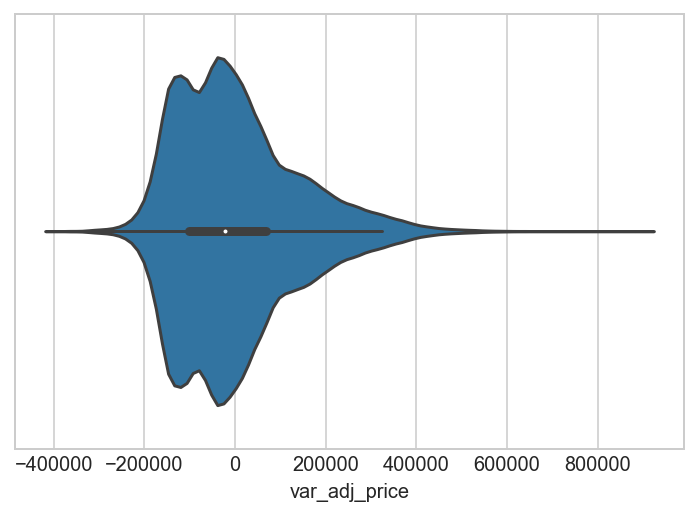

In [8]:
sns.violinplot(resale['var_adj_price'])

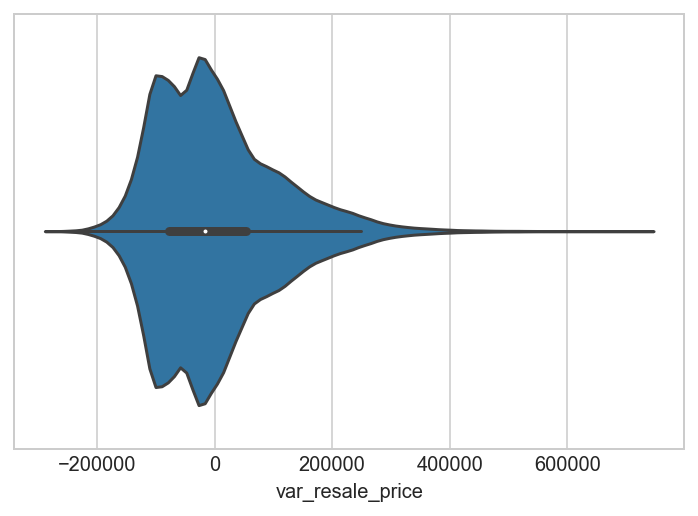

In [9]:
sns.violinplot(resale['var_resale_price'])

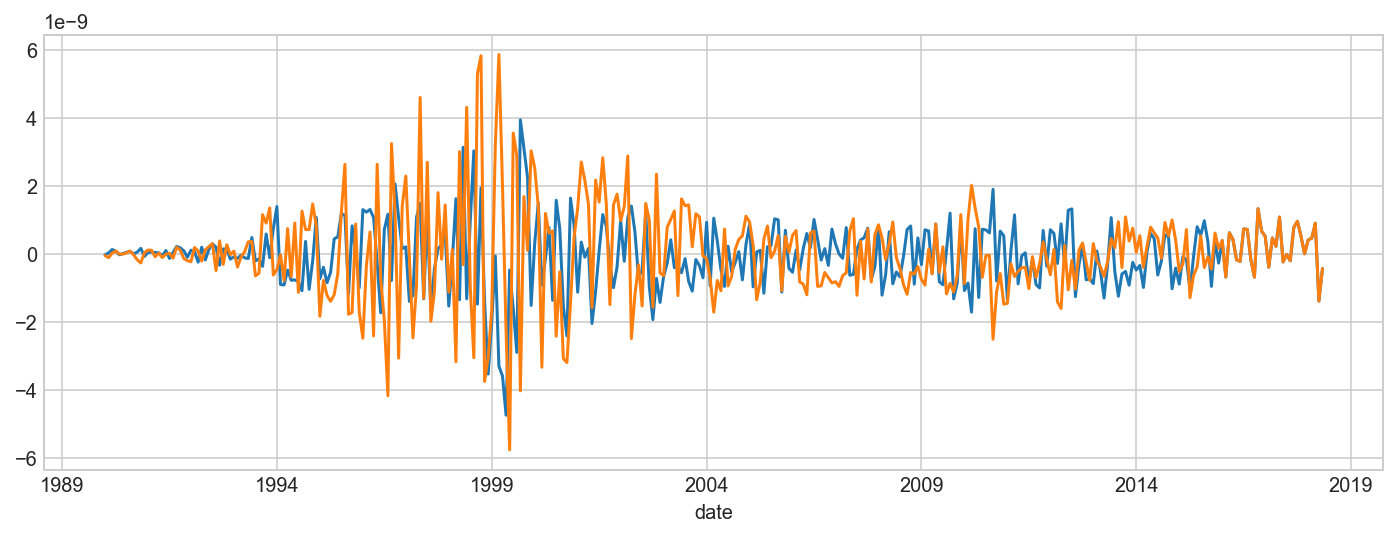

In [10]:
plt.figure(figsize = (12,4))
resale.groupby('date').mean()['var_resale_price'].plot()
resale.groupby('date').mean()['var_adj_price'].plot()

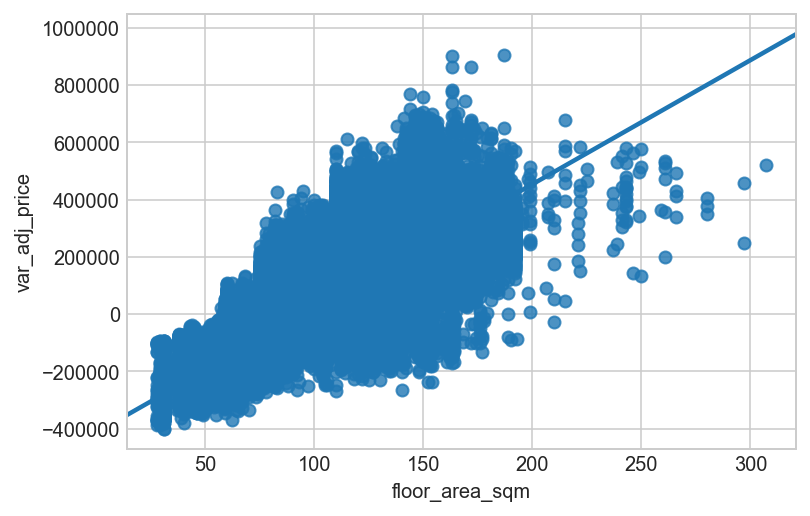

In [11]:
graph_df1 = resale[resale['year']<=2014]
sns.regplot('floor_area_sqm','var_adj_price',graph_df1)

In [12]:
# From Part2_EDA, some of the flat models have been subsumed into 'flat_model_OTHERS' 
# Instead of dropping the first variable, we will drop 'falt_model_Others instead
df1 = resale[['flat_model_PREMIUM', 'flat_model_IMPROVED', 'flat_model_MODEL_A']]
df2 = pd.get_dummies(resale[['flat_model']]).drop('flat_model_OTHERS',axis = 1)
df3 = pd.get_dummies(resale[dummy_col],drop_first=True)
df4 = resale[['latitude', 'longitude']]
df5 = resale[['calculated_remaining_lease','floor_area_sqm','lease_commence_date']]

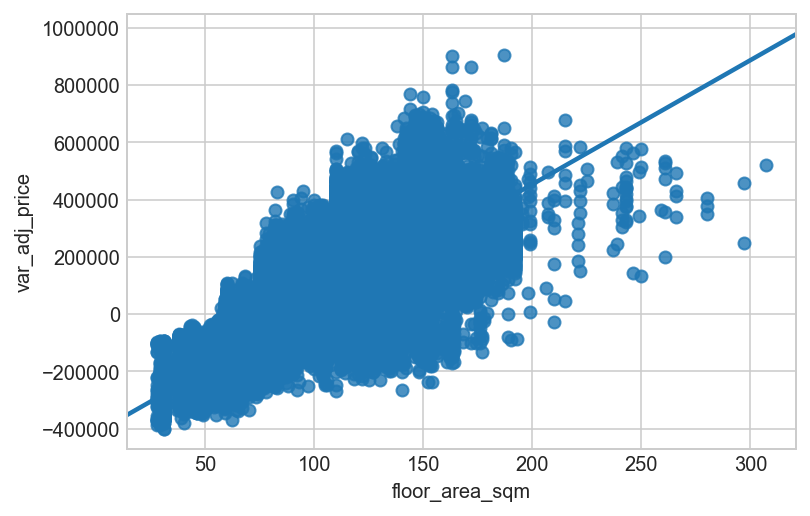

In [13]:
df = pd.concat([df1,df2,df3,df4,df5,resale[['var_resale_price','var_adj_price','year']]],axis=1)
graph_df2 = df[(df['year']<=2014)]
sns.regplot('floor_area_sqm','var_adj_price',graph_df2)

In [14]:
all(graph_df1['floor_area_sqm'] == graph_df2['floor_area_sqm'])

True

### Modelling 

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet, ElasticNetCV, LassoCV, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

In [16]:
def Obtain_summary(estimator,X_train, y_train, X_test, y_test):
    scores = cross_val_score(estimator, X_train, y_train, cv=10)
    score_test = estimator.score(X_test,y_test)
    print 'Mean of scores: {} | Std of scores: {}'.format(np.mean(scores), np.std(scores))
    print 'Test score: {}'.format(score_test)
    
    return {'mean_score':np.mean(scores), 
            'std_score':np.std(scores), 
            'scores':scores,
            'for_compare': [np.mean(scores),np.std(scores), score_test]
           }

def Obtain_coefficients(estimator,X_train,y_train,X):
    coefficient = pd.DataFrame({'variable':X.columns,
                                'coef':estimator.coef_,
                                'abs_coef':np.abs(estimator.coef_)})
    feat_coeff = coefficient[coefficient['abs_coef']>0]
    print '{} out of {} features are selected.' .format(feat_coeff.shape[0],len(X.columns))
    return coefficient
    

def Add_model(model_name,summary,df):
    row = pd.DataFrame([model_name]+summary['for_compare'],
                       index=['model','train_mean_score','train_std_score','test_score']).T
    
    if type(df) == list:
        df = pd.DataFrame(columns=['model','train_mean_score','train_std_score','test_score'])
        new_df = pd.concat([df,row])
    else:
        new_df = pd.concat([df,row])
        
    return new_df

In [17]:
def Analyse_coef(coefficient,df):
    print 'Coefficients not used: {}'.format([col for col in df.columns 
                                              if col not in list(coefficient[coefficient['abs_coef'] != 0].variable)])
    
    print coefficient.sort_values('abs_coef',ascending = False).head(10)
    
    ##################First Row of Graphs##################
    fig,ax = plt.subplots(ncols=2,nrows = 1,figsize=(14,3))
    #STOREY_RANGE Graph [0][0]
    storey_col = [col for col in X.columns if 'storey' in col] 
    df_storey_col = pd.DataFrame(coefficient.set_index('variable')['coef'].T[storey_col].sort_values(ascending=False))

    sns.barplot(y=df_storey_col.index,x = df_storey_col.coef,orient='h',ax=ax[0])
    ax[0].set_ylabel('Storey Range')
    ax[0].set_xlabel('Coefficients')
    ax[0].set_title('Analysis of Coefficients for Storey Range')

    #FLAT_TYPE Graph [0][1]
    flat_type_col = [col for col in X.columns if 'flat_type' in col] 
    df_flat_type = pd.DataFrame(coefficient.set_index('variable')['coef'].T[flat_type_col ].sort_values(ascending =False))
    sns.barplot(y=df_flat_type.index,x = df_flat_type.coef,orient='h',ax=ax[1])
    ax[1].set_yticklabels([col[10:] for col in df_flat_type.index])
    ax[1].set_ylabel('Flat Type')
    ax[1].set_xlabel('Coefficients')
    ax[1].set_title('Analysis of Coefficients for Flat Type');

    ##################Second Row of Graphs##################
    fig,ax = plt.subplots(ncols=2,nrows = 1,figsize=(14,4))
    #FLAT_MODEL Graph [1][0]
    flat_model_col = [col for col in X.columns if 'flat_model' in col] 
    df_flat_model = pd.DataFrame(coefficient.set_index('variable')['coef'].T[flat_model_col].sort_values(ascending = False))
    sns.barplot(y=df_flat_model.index,x = df_flat_model.coef,orient='h',ax=ax[0])
    ax[0].set_yticklabels([col[11:] for col in df_flat_model.index])
    ax[0].set_ylabel('Flat Model')
    ax[0].set_xlabel('Coefficients')
    ax[0].set_title('Analysis of Coefficients for Flat Model');

    #Month Graph [1][1]
    try: 
        flat_month = [col for col in X.columns if 'month' in col] 
        df_month = pd.DataFrame(coefficient.set_index('variable')['coef'].T[flat_month])
        sns.barplot(y=df_month.index,x = df_month.coef,orient='h',ax=ax[1])
        ax[1].set_yticklabels([col[:6]+col[-2:] for col in df_month.index])
        ax[1].set_ylabel('Flat Model')
        ax[1].set_xlabel('Coefficients')
        ax[1].set_title('Analysis of Coefficients for Flat Model');
    except:
        pass

    ##################ThirdRow of Graphs################## 
    fig,ax = plt.subplots(ncols=2,nrows = 1,figsize=(14,6))
    #TOWN ax[0]
    flat_town = [col for col in X.columns if 'town' in col] 
    df_town = pd.DataFrame(coefficient.set_index('variable')['coef'].T[flat_town].sort_values(ascending=False))
    sns.barplot(y=df_town.index,x = df_town.coef,orient='h',ax=ax[0])
    ax[0].set_yticklabels([col[5:] for col in df_town.index])
    ax[0].set_ylabel('Flat Model')
    ax[0].set_xlabel('Coefficients')
    ax[0].set_title('Analysis of Coefficients for Flat Model');

    #YEAR ax[1]
    try:
        flat_year = [col for col in X.columns if 'year' in col] 
        df_year = pd.DataFrame(coefficient.set_index('variable')['coef'].T[flat_year])
        sns.barplot(y=df_year.index,x = df_year.coef,orient='h',ax=ax[1])
        ax[1].set_yticklabels([col[5:] for col in df_year.index])
        ax[1].set_ylabel('Flat Model')
        ax[1].set_xlabel('Coefficients')
        ax[1].set_title('Analysis of Coefficients for Flat Model')
    except:
        pass

<a id='iter1'></a>
## Iteration 1
| **X** | **y**|
|------|------|
| dummy: ['flat_model','flat_type', 'storey', 'year', 'month_str', 'town']] <br> cont.: ['latitude', 'longitude',calculated remaining lease]  | resale['resale_price']|

<a id='1slr'></a>
#### Iteration1: Single Variable Linear Regression
want to see the effect of each single variable on resale_price

In [18]:
df = pd.concat([df1,df2,df3,df4,df5,resale[['var_resale_price','var_adj_price','year']]],axis=1)
train = df[(df['year']<2014)]
test = df[df['year']>=2014]

In [19]:
summary_SLR = pd.DataFrame(columns=['model','train_mean_score','train_std_score','test_score'])

for col in train.drop(['var_resale_price','var_adj_price','year'],axis=1).columns:
    X_train = train[[col]]
    y_train = train['var_resale_price']
    X_test = test[[col]]
    y_test = test['var_resale_price']
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    print col
    summary_model = Obtain_summary(linreg,X_train, y_train, X_test, y_test)
    summary_SLR = Add_model(col,summary_model,summary_SLR)
    print '--------------------------------------'

flat_model_PREMIUM
Mean of scores: 0.00789022351724 | Std of scores: 0.00642378617925
Test score: -0.00174284606457
--------------------------------------
flat_model_IMPROVED
Mean of scores: 0.00700276832702 | Std of scores: 0.00620630606263
Test score: 0.00177660466331
--------------------------------------
flat_model_MODEL_A
Mean of scores: -0.000178998556608 | Std of scores: 0.000282969029879
Test score: -0.000451178334096
--------------------------------------
flat_model_ADJOINED FLAT
Mean of scores: -0.000314569777945 | Std of scores: 0.00322915758843
Test score: 0.00139703009473
--------------------------------------
flat_model_APARTMENT
Mean of scores: 0.102281296292 | Std of scores: 0.047905744108
Test score: 0.00621568391824
--------------------------------------
flat_model_DBSS
Mean of scores: -1.32836823527e-05 | Std of scores: 1.44180806073e-05
Test score: 0.0
--------------------------------------
flat_model_MAISONETTE
Mean of scores: 0.126292323597 | Std of scores: 0.0559

Mean of scores: -1.35181855381e-05 | Std of scores: 1.46782386658e-05
Test score: 0.0
--------------------------------------
month_str_07
Mean of scores: -1.56450057318e-05 | Std of scores: 1.63542386794e-05
Test score: 0.0
--------------------------------------
month_str_08
Mean of scores: -2.31241913707e-05 | Std of scores: 2.09298407924e-05
Test score: 0.0
--------------------------------------
month_str_09
Mean of scores: -6.5280020423e-05 | Std of scores: 7.65585367548e-05
Test score: 0.0
--------------------------------------
month_str_10
Mean of scores: -2.58969301539e-05 | Std of scores: 3.64153947584e-05
Test score: 0.0
--------------------------------------
month_str_11
Mean of scores: -1.70608567763e-05 | Std of scores: 1.37638125739e-05
Test score: 0.0
--------------------------------------
month_str_12
Mean of scores: -1.34933174053e-05 | Std of scores: 1.46331169848e-05
Test score: 0.0
--------------------------------------
town_BEDOK
Mean of scores: 0.00253970191817 | St

In [20]:
summary_SLR.sort_values('train_mean_score',ascending=False).head(20)

,model,train_mean_score,train_std_score,test_score
0,floor_area_sqm,0.688384,0.110409,0.419719
0,flat_type_3 ROOM,0.372485,0.0542645,0.240759
0,flat_type_EXECUTIVE,0.263488,0.0678104,0.149284
0,flat_type_5 ROOM,0.211443,0.029164,0.117723
0,lease_commence_date,0.173903,0.0581218,0.0889283
0,calculated_remaining_lease,0.16632,0.0524869,0.0348281
0,flat_model_MAISONETTE,0.126292,0.0559007,0.0839373
0,flat_model_APARTMENT,0.102281,0.0479057,0.00621568
0,flat_model_NEW GENERATION,0.0953392,0.0250461,0.0698064
0,town_PASIR RIS,0.0301881,0.0237473,-0.000726208


In [21]:
summary_SLR.sort_values('train_mean_score',ascending=True).head(20)

,model,train_mean_score,train_std_score,test_score
0,latitude,-0.00103952,0.00273988,-0.00524745
0,town_BUKIT MERAH,-0.000709597,0.00156274,0.00317119
0,flat_model_ADJOINED FLAT,-0.00031457,0.00322916,0.00139703
0,flat_model_MODEL_A,-0.000178999,0.000282969,-0.000451178
0,year_str_2002,-0.000133286,0.000250773,0
0,year_str_2011,-7.34157e-05,0.000118542,0
0,month_str_09,-6.528e-05,7.65585e-05,0
0,year_str_1998,-5.74326e-05,9.04259e-05,0
0,year_str_2007,-4.56433e-05,8.21936e-05,0
0,year_str_2004,-3.11993e-05,3.50077e-05,0


**Insights** <br>
From the summary scores, the factors that are quite important to var_resale_price are: 
- flat_area_sqm
- flat_type
- flat model <br>

The factors that are not important are:
- year and month

<a id='1mlrcat'></a>
#### Iteration 1: Multiple Variable Linear Regression by Category

In [22]:
summary_MLR = pd.DataFrame(columns=['model','train_mean_score','train_std_score','test_score'])

for cat in ['flat_type','storey','year','month_str','town','flat_model']:
    print cat
    cat_pred = [col for col in train.columns if cat in col]
    X_train = train[cat_pred]
    y_train = train['var_resale_price']
    X_test = test[cat_pred]
    y_test = test['var_resale_price']
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    summary_model = Obtain_summary(linreg,X_train, y_train, X_test, y_test)
    summary_MLR = Add_model(cat,summary_model,summary_MLR)
    print '--------------------------------'

flat_type
Mean of scores: 0.687847866634 | Std of scores: 0.107545082039
Test score: 0.422047465164
--------------------------------
storey
Mean of scores: 0.0555335855999 | Std of scores: 0.0388184612475
Test score: 0.134004722675
--------------------------------
year
Mean of scores: -0.000296556560105 | Std of scores: 0.000304291969044
Test score: -1.30310421297e+17
--------------------------------
month_str
Mean of scores: -0.000128527397263 | Std of scores: 0.000129952335474
Test score: 0.0
--------------------------------
town
Mean of scores: 0.105074757483 | Std of scores: 0.0403622764603
Test score: 0.0277535169555
--------------------------------
flat_model
Mean of scores: 0.363856502202 | Std of scores: 0.065826388688
Test score: 0.253738714473
--------------------------------


In [23]:
summary_MLR.sort_values('train_mean_score',ascending=False)

,model,train_mean_score,train_std_score,test_score
0,flat_type,0.687848,0.107545,0.422047
0,flat_model,0.363857,0.0658264,0.253739
0,town,0.105075,0.0403623,0.0277535
0,storey,0.0555336,0.0388185,0.134005
0,month_str,-0.000128527,0.000129952,0
0,year,-0.000296557,0.000304292,-1.3031e+17


**Insights** <br>
From the summary scores, the dummy factors that are quite important to resale_price are:
- year 
- flat_type
- flat_model

The factors that are not important are:
- month and surprisingly,
- storey

This is in sync with the SLR results above. 

<a id='iter2'></a>
## Iteration 2
| **X** | **y**|
|------|------|
| dummy: ['flat_model','flat_type', 'storey', 'year', 'month_str', 'town']] <br> cont.: ['latitude', 'longitude',calculated remaining lease]  | resale['adj_price']|

<a id='2slr'></a>
#### Iteration2: Single Variable Linear Regression
Want to see the effect of each single variable on resale_price

In [24]:
summary_SLR = pd.DataFrame(columns=['model','train_mean_score','train_std_score','test_score'])

for col in train.drop(['var_resale_price','var_adj_price','year'],axis=1).columns:
    X_train = train[[col]]
    y_train = train['var_adj_price']
    X_test = test[[col]]
    y_test = test['var_adj_price']
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    print col
    summary_model = Obtain_summary(linreg,X_train, y_train, X_test, y_test)
    summary_SLR = Add_model(col,summary_model,summary_SLR)
    print '-----------------------------'

flat_model_PREMIUM
Mean of scores: 0.00732315489242 | Std of scores: 0.00600763178714
Test score: -0.00563013094299
-----------------------------
flat_model_IMPROVED
Mean of scores: 0.00737669014868 | Std of scores: 0.00560783424234
Test score: 0.000655792936396
-----------------------------
flat_model_MODEL_A
Mean of scores: -0.000244121347609 | Std of scores: 0.00049943058603
Test score: -0.00106893629663
-----------------------------
flat_model_ADJOINED FLAT
Mean of scores: -0.000104162965748 | Std of scores: 0.00225416487727
Test score: 0.00147605142861
-----------------------------
flat_model_APARTMENT
Mean of scores: 0.0903470984589 | Std of scores: 0.0555387783299
Test score: -0.0453922818585
-----------------------------
flat_model_DBSS
Mean of scores: -1.24757873661e-05 | Std of scores: 1.53735205905e-05
Test score: 1.11022302463e-16
-----------------------------
flat_model_MAISONETTE
Mean of scores: 0.124004745622 | Std of scores: 0.0594866793499
Test score: 0.0857687078629
-

Mean of scores: -1.47750170381e-05 | Std of scores: 1.70798925114e-05
Test score: 1.11022302463e-16
-----------------------------
month_str_08
Mean of scores: -2.38325784035e-05 | Std of scores: 2.34946983207e-05
Test score: 3.33066907388e-16
-----------------------------
month_str_09
Mean of scores: -5.86417031299e-05 | Std of scores: 6.99382908187e-05
Test score: 1.11022302463e-16
-----------------------------
month_str_10
Mean of scores: -2.68533138453e-05 | Std of scores: 3.85771448371e-05
Test score: 1.11022302463e-16
-----------------------------
month_str_11
Mean of scores: -1.81682507618e-05 | Std of scores: 1.63540427782e-05
Test score: 1.11022302463e-16
-----------------------------
month_str_12
Mean of scores: -1.26694864155e-05 | Std of scores: 1.56012175652e-05
Test score: 3.33066907388e-16
-----------------------------
town_BEDOK
Mean of scores: 0.00270593835959 | Std of scores: 0.00135582976557
Test score: 0.00243654338831
-----------------------------
town_BISHAN
Mean o

In [25]:
summary_SLR.sort_values('train_mean_score',ascending=False).head(20)

,model,train_mean_score,train_std_score,test_score
0,floor_area_sqm,0.686,0.111774,0.412176
0,flat_type_3 ROOM,0.372735,0.04782,0.235838
0,flat_type_EXECUTIVE,0.253527,0.0775701,0.129198
0,flat_type_5 ROOM,0.204815,0.0372927,0.0963656
0,lease_commence_date,0.163944,0.0547116,0.0212002
0,calculated_remaining_lease,0.152927,0.0593507,-0.0713669
0,flat_model_MAISONETTE,0.124005,0.0594867,0.0857687
0,flat_model_NEW GENERATION,0.0973856,0.0177828,0.0741118
0,flat_model_APARTMENT,0.0903471,0.0555388,-0.0453923
0,town_PASIR RIS,0.0283324,0.0250561,-0.00968309


In [26]:
summary_SLR.sort_values('train_mean_score',ascending=True).head(20)

,model,train_mean_score,train_std_score,test_score
0,latitude,-0.00144303,0.00448988,-0.0119813
0,town_BUKIT MERAH,-0.000762637,0.000617412,0.00163716
0,flat_model_MODEL_A,-0.000244121,0.000499431,-0.00106894
0,year_str_2002,-0.0001374,0.000256421,3.33067e-16
0,flat_model_ADJOINED FLAT,-0.000104163,0.00225416,0.00147605
0,month_str_09,-5.86417e-05,6.99383e-05,1.11022e-16
0,year_str_2011,-5.59258e-05,8.28747e-05,3.33067e-16
0,year_str_1998,-5.52089e-05,8.72985e-05,1.11022e-16
0,year_str_2007,-4.79304e-05,8.35222e-05,1.11022e-16
0,town_KALLANG/WHAMPOA,-3.37108e-05,0.000773462,-0.0024576


**Insights** <br>
From the summary scores, the factors that are quite important to adj_price are:
- floor_area_sqm
- 3 room, 5 room, executive etc --> flat_type
- lease_commence_date
- new generation, apartments, premium etc --> flat_model (a few factors only)
- Certain years
- Calculated_remaining_lease
- Storey height

The factors that are not important are:
- month
- certain towns
- certain years

Effect on adj_price is higher than effect on resale_price

<a id='2mlrcat'></a>
#### Iteration 2: Multiple Variable Linear Regression by Category

In [27]:
summary_MLR = pd.DataFrame(columns=['model','train_mean_score','train_std_score','test_score'])

for cat in ['flat_type','storey','year','month_str','town','flat_model']:
    print cat
    cat_pred = [col for col in train.columns if cat in col]
    X_train = train[cat_pred]
    y_train = train['var_adj_price']
    X_test = test[cat_pred]
    y_test = test['var_adj_price']
    
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    summary_model = Obtain_summary(linreg,X_train, y_train, X_test, y_test)
    summary_MLR = Add_model(cat,summary_model,summary_MLR)
    print '--------------------------------'

flat_type
Mean of scores: 0.677882688556 | Std of scores: 0.119429924343
Test score: 0.394390164516
--------------------------------
storey
Mean of scores: 0.0564495283529 | Std of scores: 0.0364232521218
Test score: 0.144965460367
--------------------------------
year
Mean of scores: -0.0002927692569 | Std of scores: 0.000300110341539
Test score: -3.87328352983e+17
--------------------------------
month_str
Mean of scores: -0.000126945529603 | Std of scores: 0.000127632351821
Test score: 1.11022302463e-16
--------------------------------
town
Mean of scores: 0.102277457977 | Std of scores: 0.0426499828769
Test score: 0.00281103522336
--------------------------------
flat_model
Mean of scores: 0.360220735536 | Std of scores: 0.0676113865675
Test score: 0.258369158188
--------------------------------


In [28]:
summary_MLR.sort_values('train_mean_score',ascending = False)

,model,train_mean_score,train_std_score,test_score
0,flat_type,0.677883,0.11943,0.39439
0,flat_model,0.360221,0.0676114,0.258369
0,town,0.102277,0.04265,0.00281104
0,storey,0.0564495,0.0364233,0.144965
0,month_str,-0.000126946,0.000127632,1.11022e-16
0,year,-0.000292769,0.00030011,-3.87328e+17


<a id='iter3a'></a>
### Iteration 3a

In [29]:
df = pd.concat([df1,df2,df3[[col for col in df3.columns if 'year' not in col]],df4,df5,resale[['var_resale_price','var_adj_price','year']]],axis=1)
train = df[df['year']<2014]
test = df[df['year']>=2014]
X = df.drop(['var_resale_price','var_adj_price','year'],axis=1)
X_train = train.drop(['var_resale_price','var_adj_price','year'],axis=1)
y_train = train['var_resale_price']
X_test = test.drop(['var_resale_price','var_adj_price','year'],axis=1)
y_test = test['var_resale_price']


In [30]:
X_train.columns

Index([u'flat_model_PREMIUM', u'flat_model_IMPROVED', u'flat_model_MODEL_A',
       u'flat_model_ADJOINED FLAT', u'flat_model_APARTMENT',
       u'flat_model_DBSS', u'flat_model_MAISONETTE',
       u'flat_model_NEW GENERATION', u'flat_model_SIMPLIFIED',
       u'flat_model_STANDARD', u'flat_model_TERRACE', u'flat_model_TYPE S',
       u'flat_type_2 ROOM', u'flat_type_3 ROOM', u'flat_type_4 ROOM',
       u'flat_type_5 ROOM', u'flat_type_EXECUTIVE',
       u'flat_type_MULTI GENERATION', u'storey_10', u'storey_13', u'storey_16',
       u'storey_20', u'storey_30', u'storey_4', u'storey_7', u'month_str_02',
       u'month_str_03', u'month_str_04', u'month_str_05', u'month_str_06',
       u'month_str_07', u'month_str_08', u'month_str_09', u'month_str_10',
       u'month_str_11', u'month_str_12', u'town_BEDOK', u'town_BISHAN',
       u'town_BUKIT BATOK', u'town_BUKIT MERAH', u'town_BUKIT PANJANG',
       u'town_BUKIT TIMAH', u'town_CENTRAL AREA', u'town_CHOA CHU KANG',
       u'town_CLEMENTI'

<a id='3amlrall'></a>
#### Iteration 3a: Multiple variable Linear regression: ALL 

In [31]:
ss=StandardScaler()

Mean of scores: 0.832776924183 | Std of scores: 0.0702273880923
Test score: -1.51138116393e+20
67 out of 67 features are selected.
Coefficients not used: []
        abs_coef          coef                    variable
5   1.650844e+16  1.650844e+16             flat_model_DBSS
11  1.167999e+16 -1.167999e+16           flat_model_TYPE S
15  6.216950e+04  6.216950e+04            flat_type_5 ROOM
16  4.845900e+04  4.845900e+04         flat_type_EXECUTIVE
14  4.792556e+04  4.792556e+04            flat_type_4 ROOM
65  3.819200e+04  3.819200e+04              floor_area_sqm
13  2.782000e+04  2.782000e+04            flat_type_3 ROOM
60  1.857250e+04 -1.857250e+04              town_WOODLANDS
48  1.774075e+04 -1.774075e+04            town_JURONG WEST
64  1.312825e+04  1.312825e+04  calculated_remaining_lease


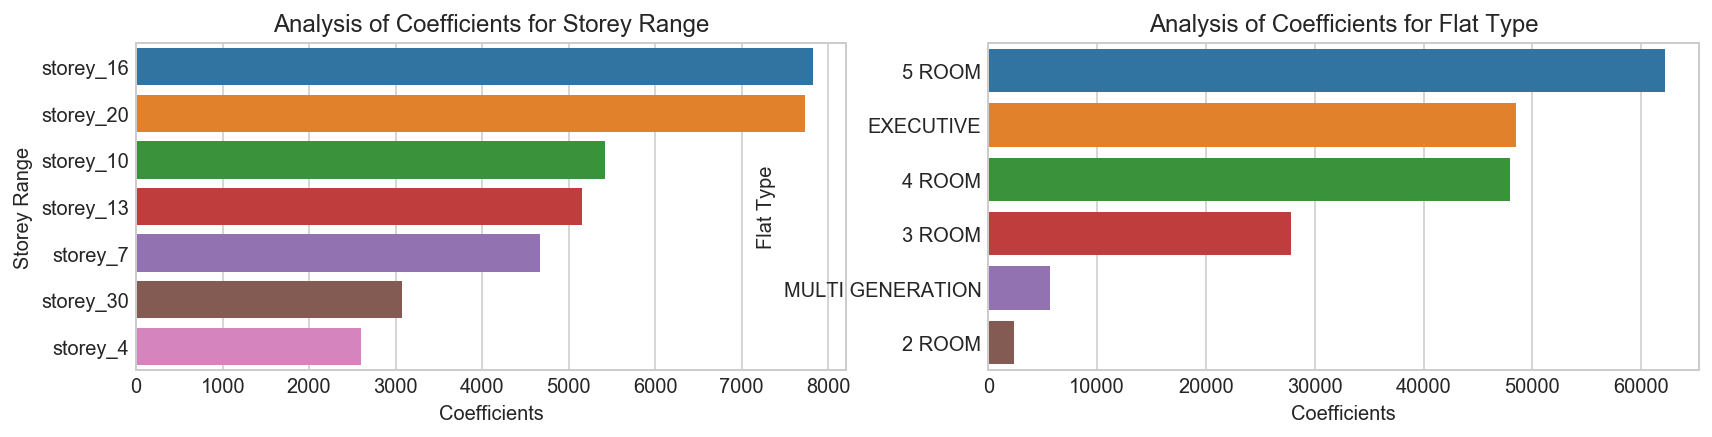

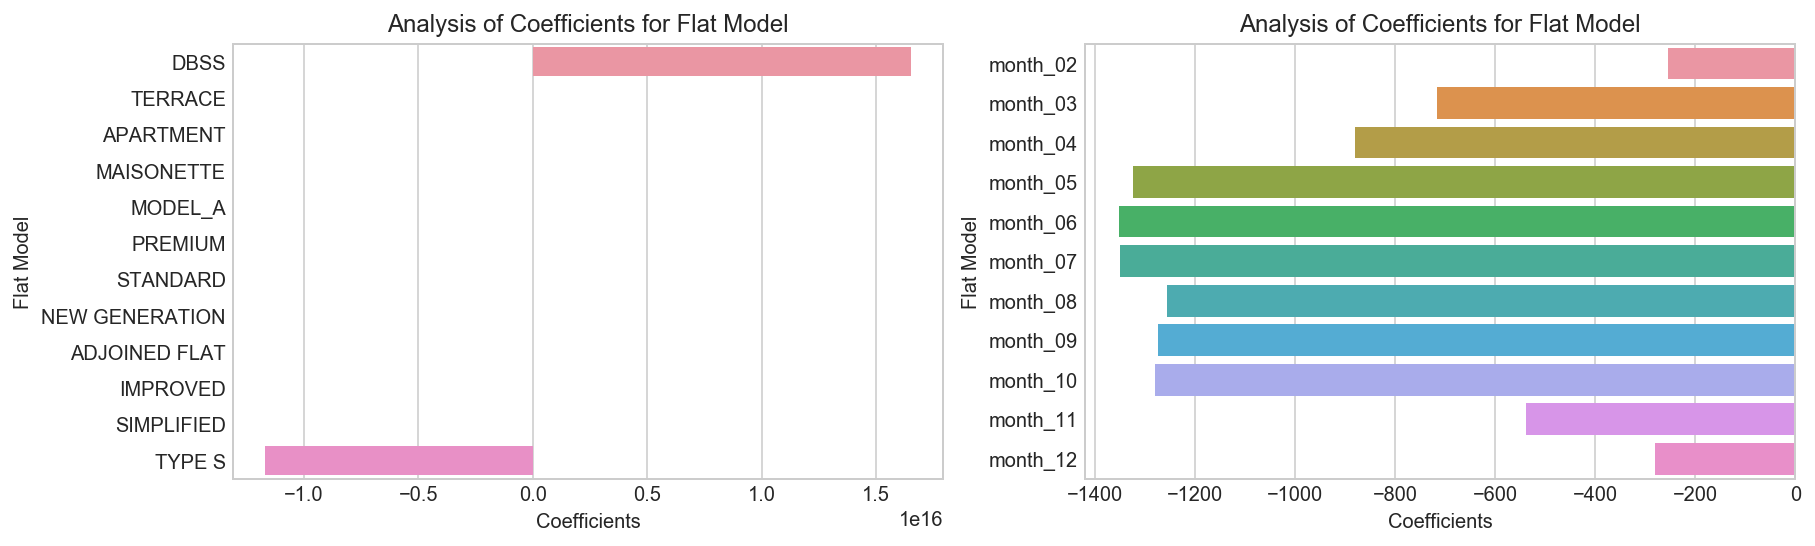

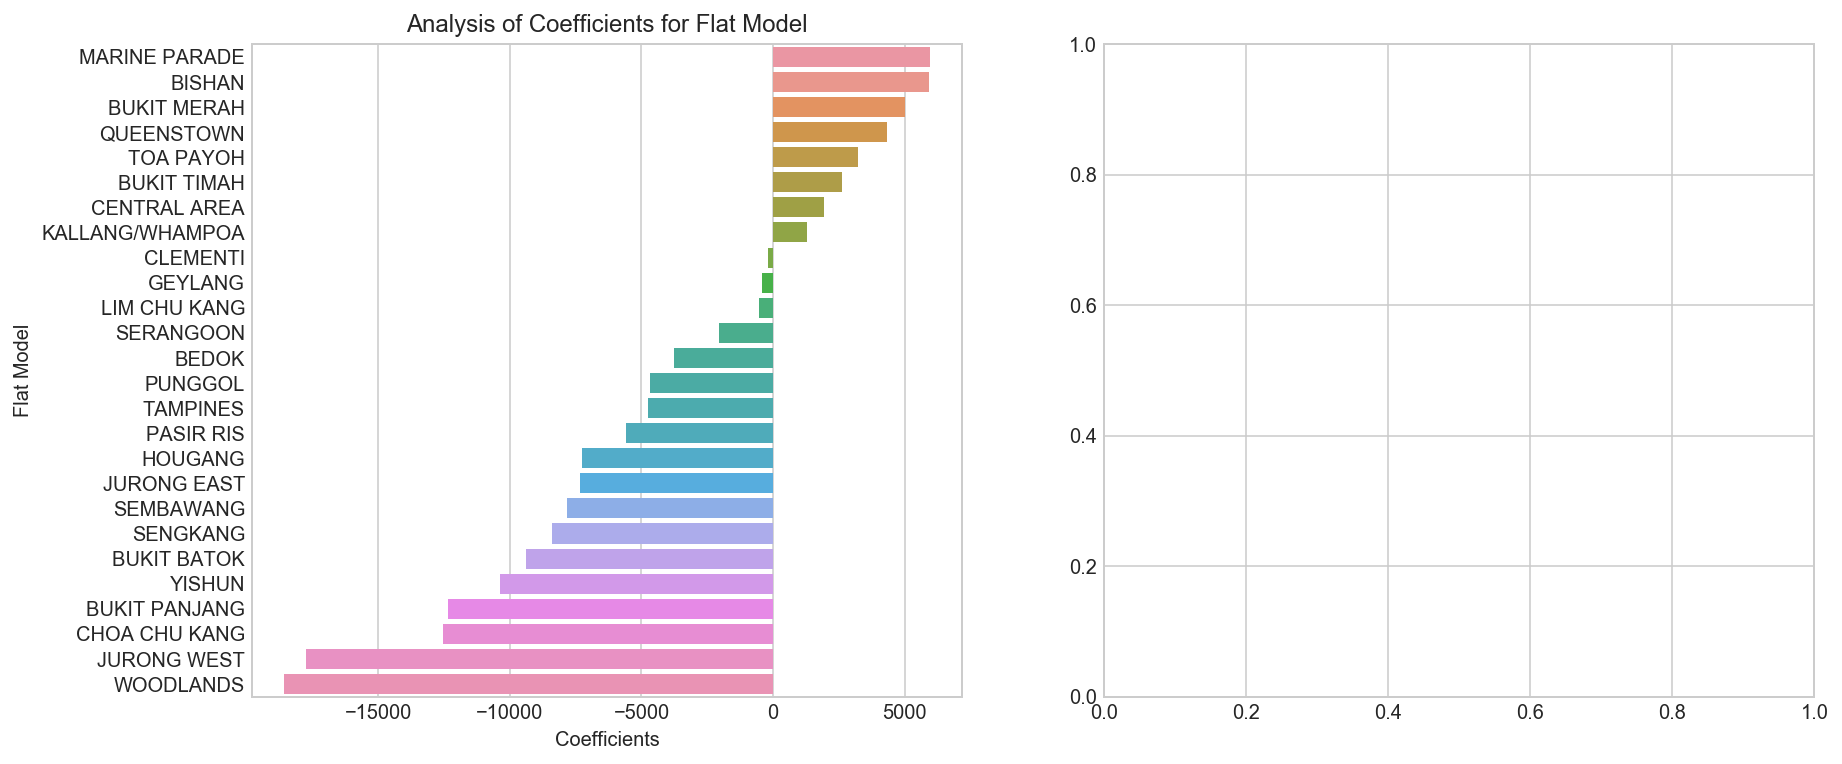

In [32]:
linreg = LinearRegression()
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('linreg',linreg)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3a_basic linreg',summary_model,[])
coeff = Obtain_coefficients(linreg,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

<a id='3aregularization'></a>
#### Iteration 3a: Ridge, Lasso, enet 

Mean of scores: 0.832779039009 | Std of scores: 0.0702240537292
Test score: 0.722603947532
65 out of 67 features are selected.
Coefficients not used: ['flat_model_DBSS', 'flat_model_TYPE S']
        abs_coef          coef                    variable
15  62131.988824  62131.988824            flat_type_5 ROOM
16  48436.797910  48436.797910         flat_type_EXECUTIVE
14  47888.789623  47888.789623            flat_type_4 ROOM
65  38196.119184  38196.119184              floor_area_sqm
13  27785.898611  27785.898611            flat_type_3 ROOM
60  18574.745141 -18574.745141              town_WOODLANDS
48  17741.846035 -17741.846035            town_JURONG WEST
64  13126.420336  13126.420336  calculated_remaining_lease
43  12536.719100 -12536.719100          town_CHOA CHU KANG
40  12356.483038 -12356.483038          town_BUKIT PANJANG


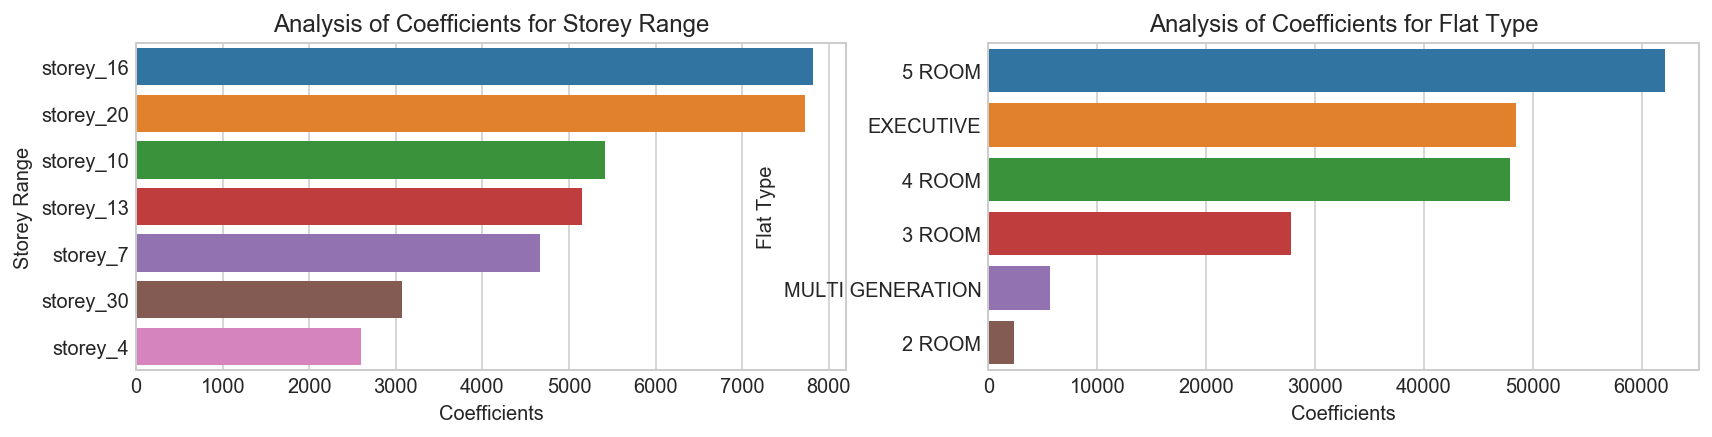

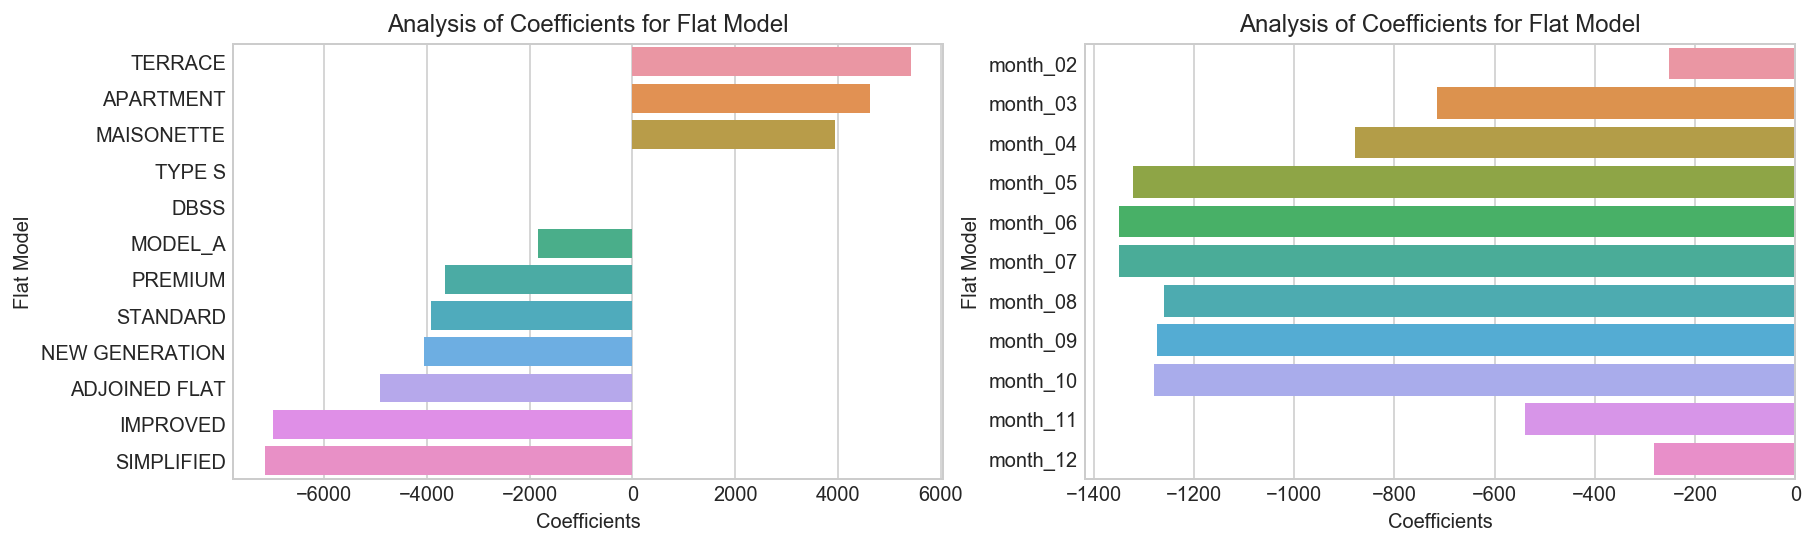

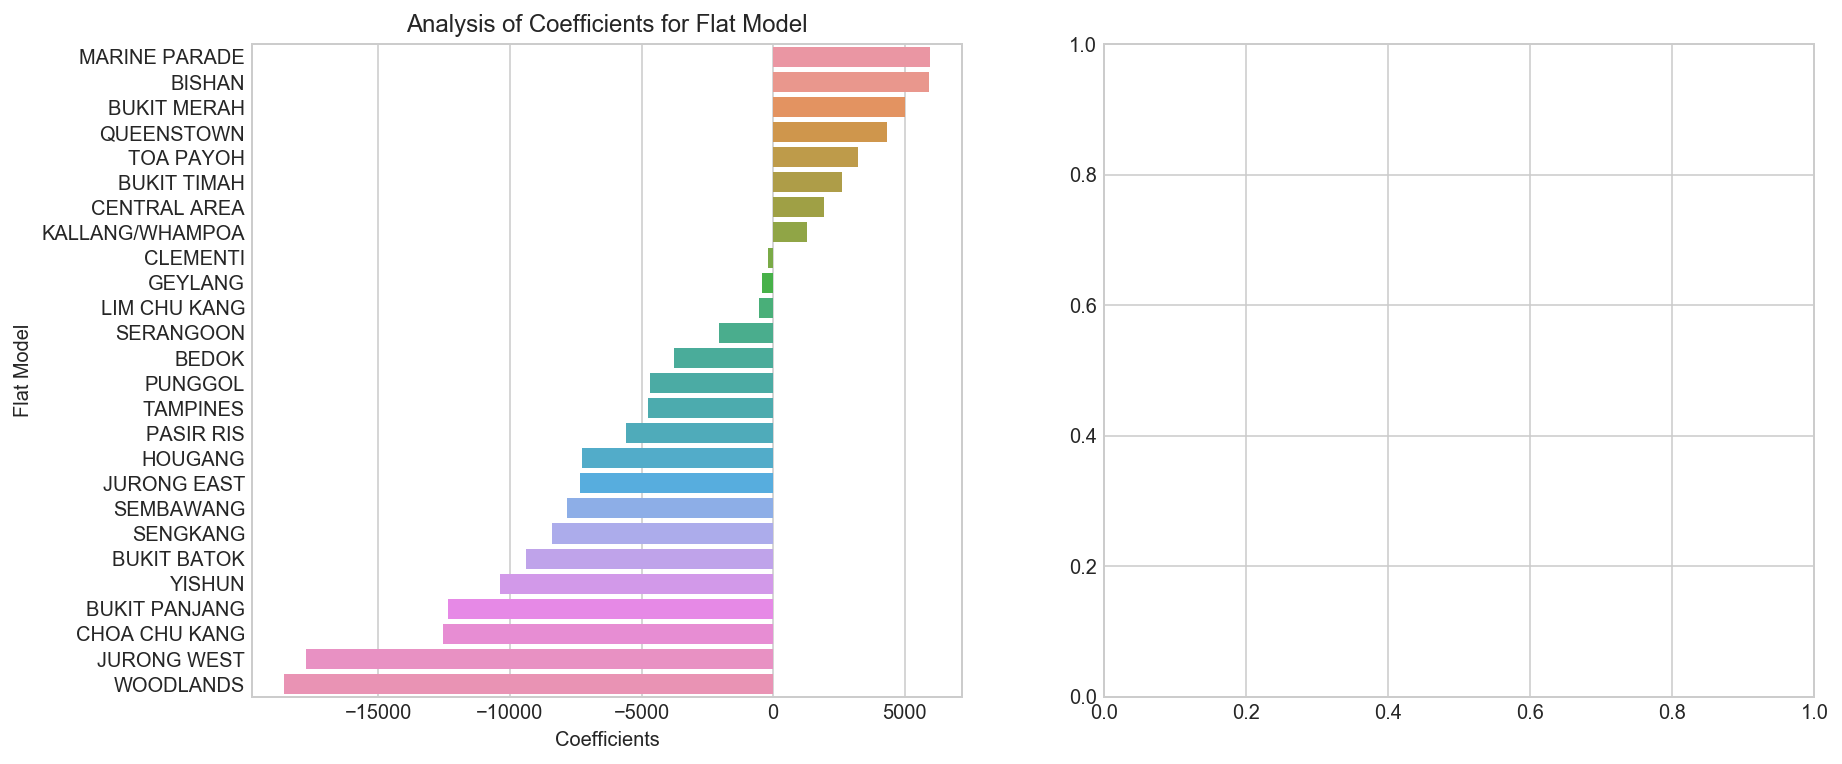

In [33]:
ridge = Ridge()
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('ridge',ridge)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3a_basic ridge',summary_model,summary)
coeff = Obtain_coefficients(ridge,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X_train)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Mean of scores: 0.832554022702 | Std of scores: 0.0687135105559
Test score: 0.717051557341
61 out of 67 features are selected.
Coefficients not used: ['flat_model_DBSS', 'flat_model_NEW GENERATION', 'flat_model_TYPE S', 'flat_type_3 ROOM', 'month_str_11', 'longitude']
        abs_coef          coef                    variable
65  44572.237870  44572.237870              floor_area_sqm
15  32939.424699  32939.424699            flat_type_5 ROOM
16  30260.702318  30260.702318         flat_type_EXECUTIVE
60  16706.593590 -16706.593590              town_WOODLANDS
14  16540.153886  16540.153886            flat_type_4 ROOM
48  15964.066671 -15964.066671            town_JURONG WEST
64  12955.601407  12955.601407  calculated_remaining_lease
40  11183.094291 -11183.094291          town_BUKIT PANJANG
43  11150.547272 -11150.547272          town_CHOA CHU KANG
61   8732.916743  -8732.916743                 town_YISHUN


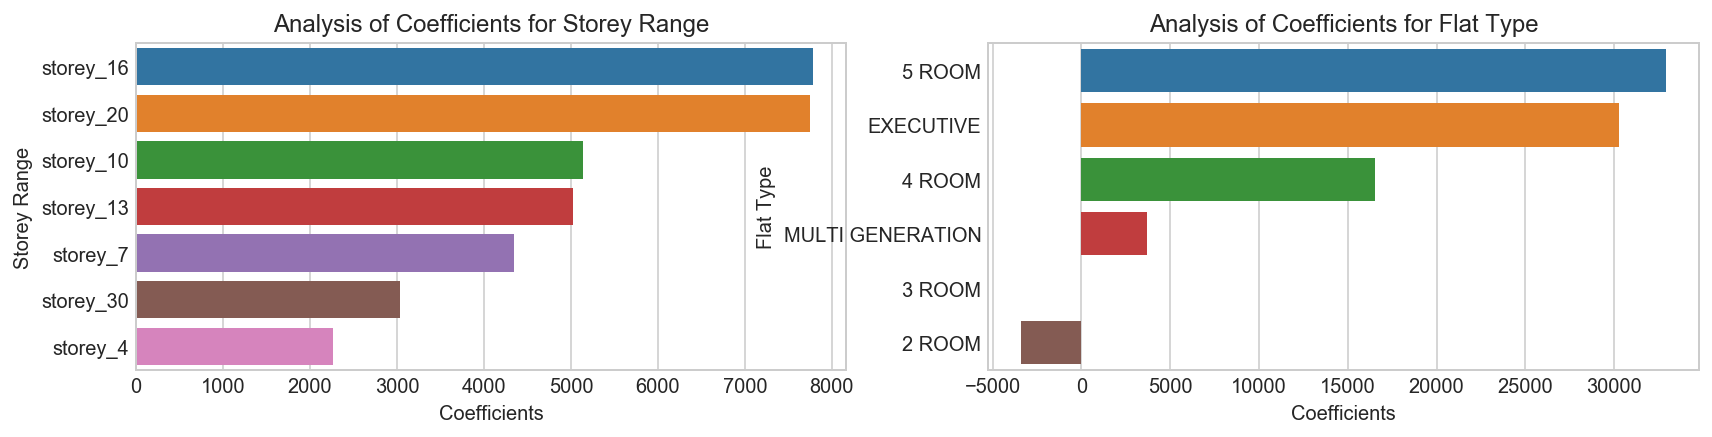

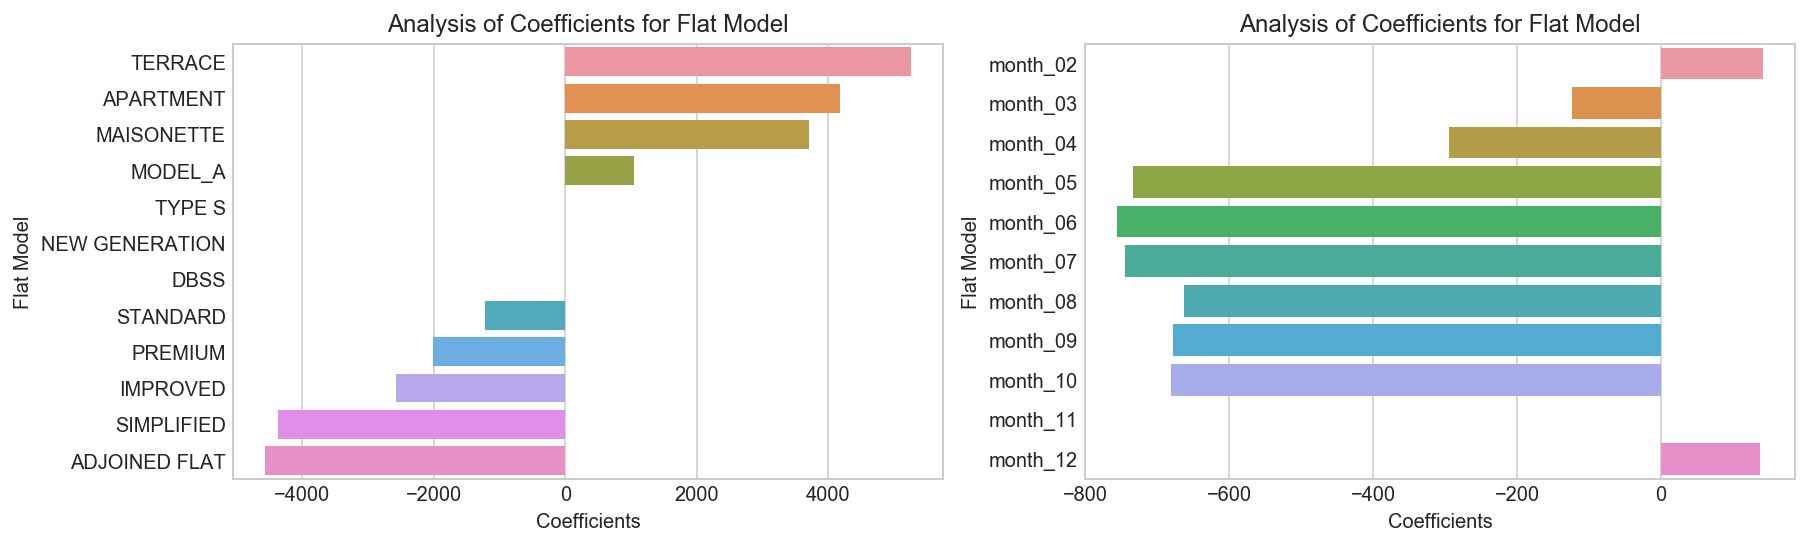

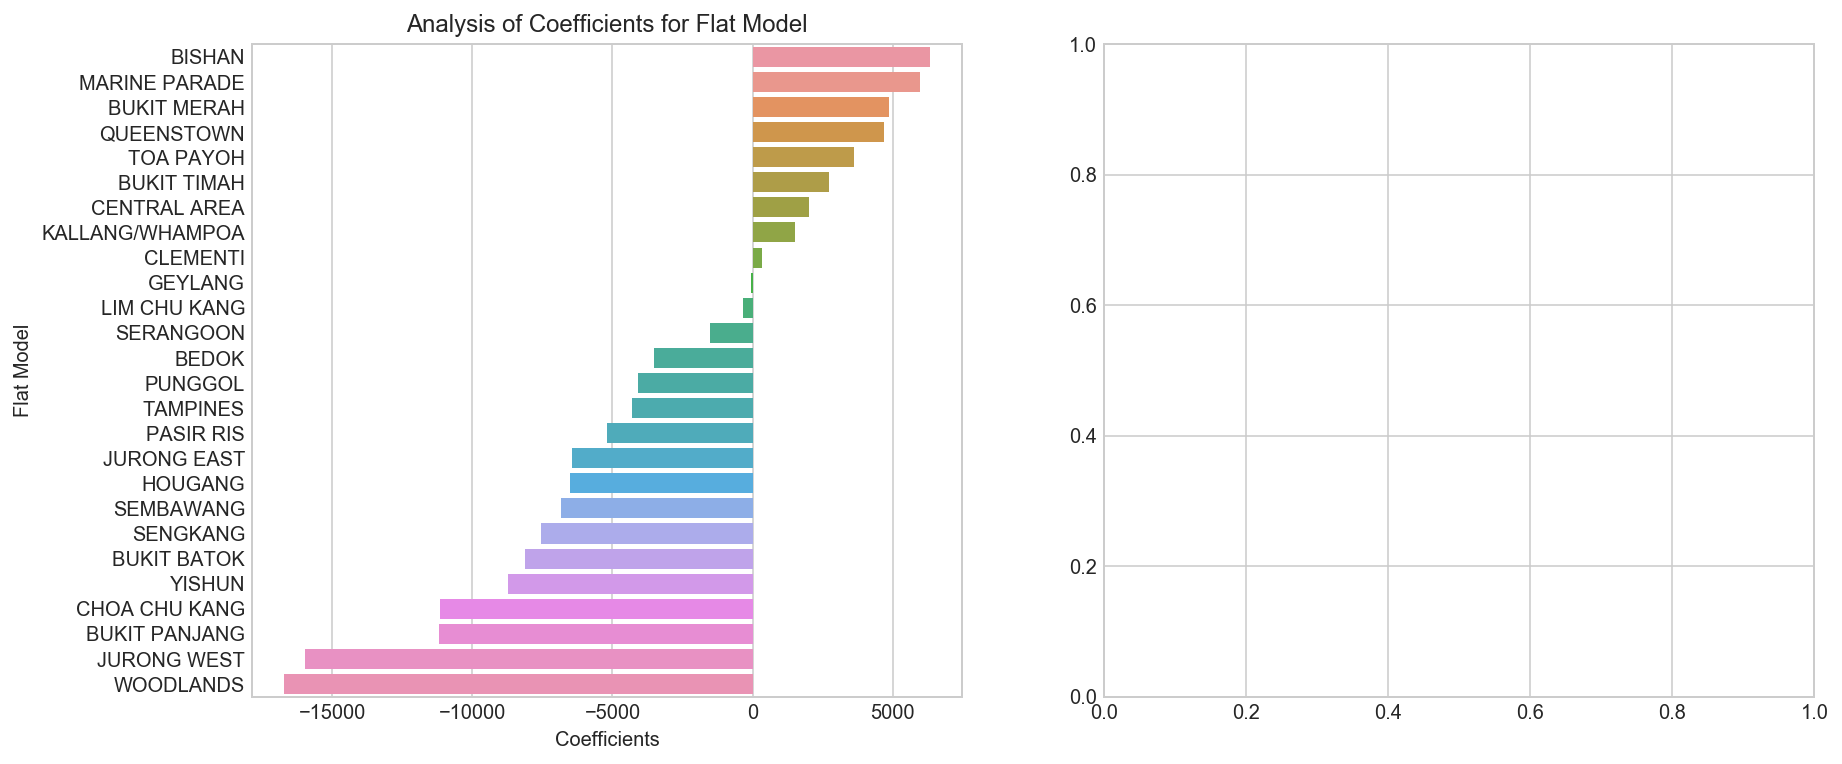

In [34]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(ss.fit_transform(X_train),y_train)
lasso = Lasso(alpha=optimal_lasso.alpha_)
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('lasso',lasso)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3a_basic lasso',summary_model,summary)
coeff = Obtain_coefficients(lasso,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Mean of scores: 0.832554022702 | Std of scores: 0.0687135105559
Test score: 0.717051557341
61 out of 67 features are selected.
Coefficients not used: ['flat_model_DBSS', 'flat_model_NEW GENERATION', 'flat_model_TYPE S', 'flat_type_3 ROOM', 'month_str_11', 'longitude']
        abs_coef          coef                    variable
65  44572.237870  44572.237870              floor_area_sqm
15  32939.424699  32939.424699            flat_type_5 ROOM
16  30260.702318  30260.702318         flat_type_EXECUTIVE
60  16706.593590 -16706.593590              town_WOODLANDS
14  16540.153886  16540.153886            flat_type_4 ROOM
48  15964.066671 -15964.066671            town_JURONG WEST
64  12955.601407  12955.601407  calculated_remaining_lease
40  11183.094291 -11183.094291          town_BUKIT PANJANG
43  11150.547272 -11150.547272          town_CHOA CHU KANG
61   8732.916743  -8732.916743                 town_YISHUN


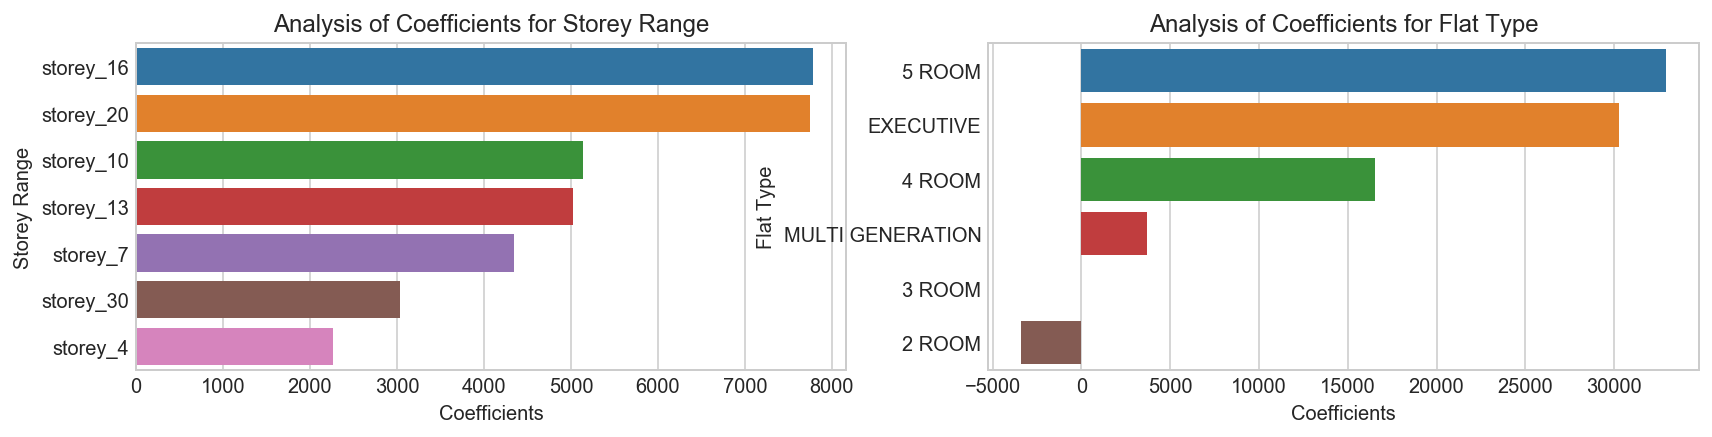

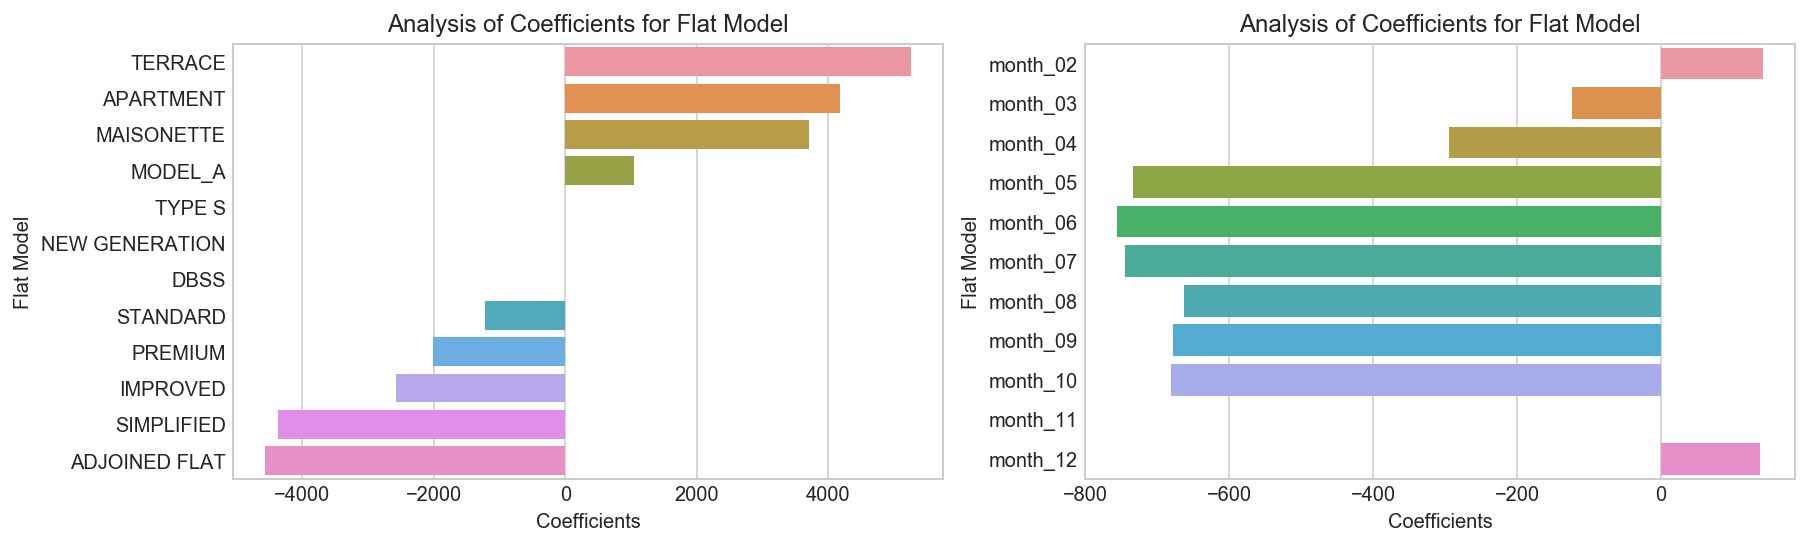

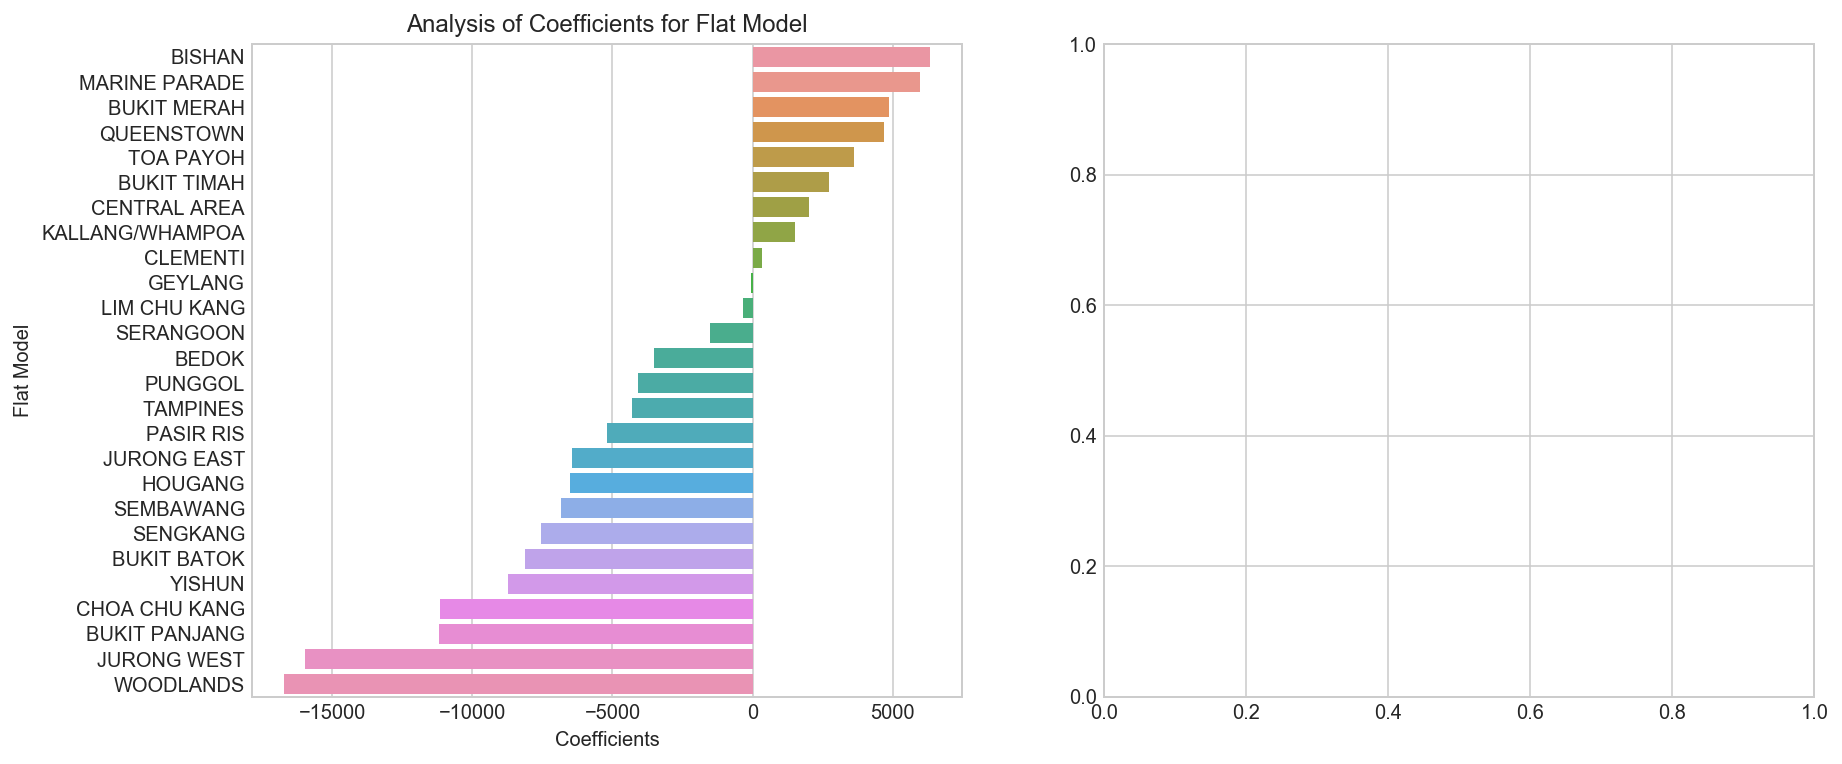

In [35]:
l1_ratios = np.linspace(0.01, 1.0, 25)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=30, cv=10,
                            verbose=1)
optimal_enet.fit(ss.fit_transform(X_train),y_train)
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('enet',enet)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3a_basic enet',summary_model,summary)
coeff = Obtain_coefficients(enet,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

In [36]:
summary

,model,train_mean_score,train_std_score,test_score
0,iter3a_basic linreg,0.832777,0.0702274,-1.51138e+20
0,iter3a_basic ridge,0.832779,0.0702241,0.722604
0,iter3a_basic lasso,0.832554,0.0687135,0.717052
0,iter3a_basic enet,0.832554,0.0687135,0.717052


<a id='iter3b'></a>
### Iteration 3b

In [40]:
df = pd.concat([df1,df2,df3[[col for col in df3.columns if 'year' not in col and 'month' not in col]],df4,df5,resale[['var_resale_price','var_adj_price','year']]],axis=1)

train = df[df['year']<2014]
test = df[df['year']>=2014]

X = df.drop(['var_resale_price','var_adj_price','year'],axis=1)
X_train = train.drop(['var_resale_price','var_adj_price','year'],axis=1)
y_train = train['var_resale_price']
X_test = test.drop(['var_resale_price','var_adj_price','year'],axis=1)
y_test = test['var_resale_price']


<a id='3bmlrall'></a>
#### Iteration 3b: Multiple variable Linear regression: ALL 

Mean of scores: 0.832832835685 | Std of scores: 0.0705592226085
Test score: -1.00830259756e+17
56 out of 56 features are selected.
Coefficients not used: []
        abs_coef          coef                    variable
5   4.366932e+14  4.366932e+14             flat_model_DBSS
11  2.619413e+14  2.619413e+14           flat_model_TYPE S
15  6.208394e+04  6.208394e+04            flat_type_5 ROOM
16  4.840508e+04  4.840508e+04         flat_type_EXECUTIVE
14  4.783604e+04  4.783604e+04            flat_type_4 ROOM
54  3.818619e+04  3.818619e+04              floor_area_sqm
13  2.773892e+04  2.773892e+04            flat_type_3 ROOM
49  1.855442e+04 -1.855442e+04              town_WOODLANDS
37  1.772571e+04 -1.772571e+04            town_JURONG WEST
53  1.316701e+04  1.316701e+04  calculated_remaining_lease


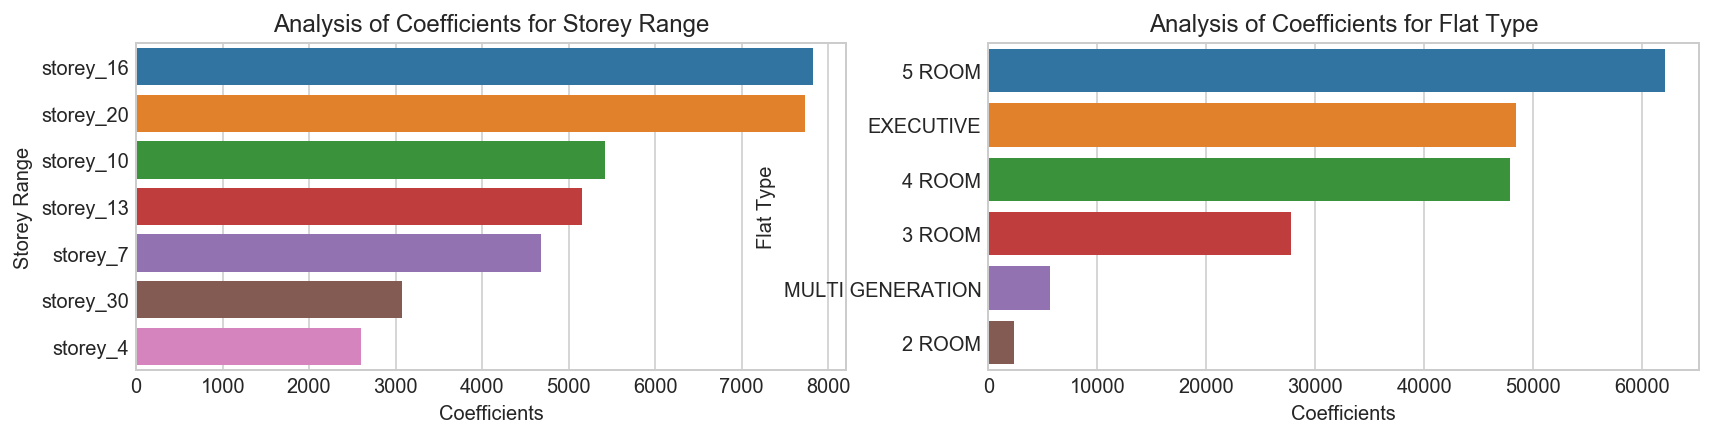

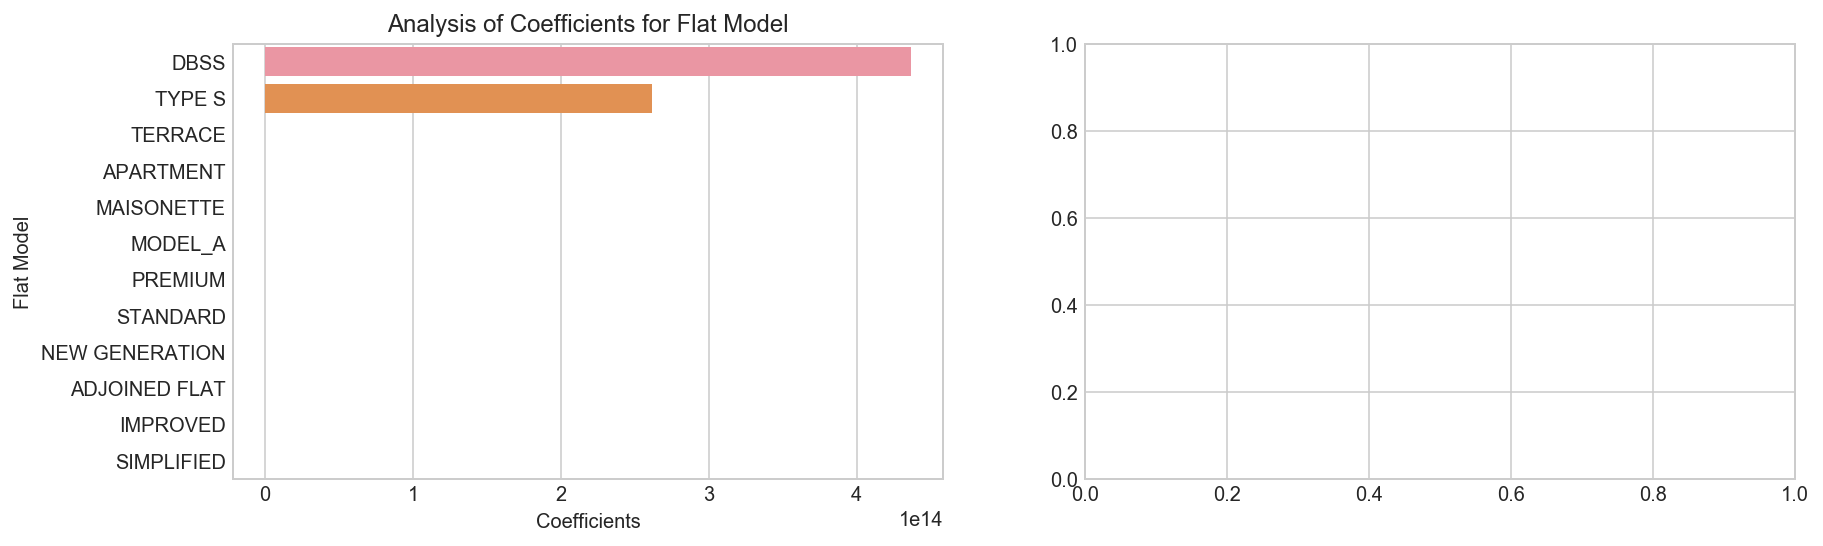

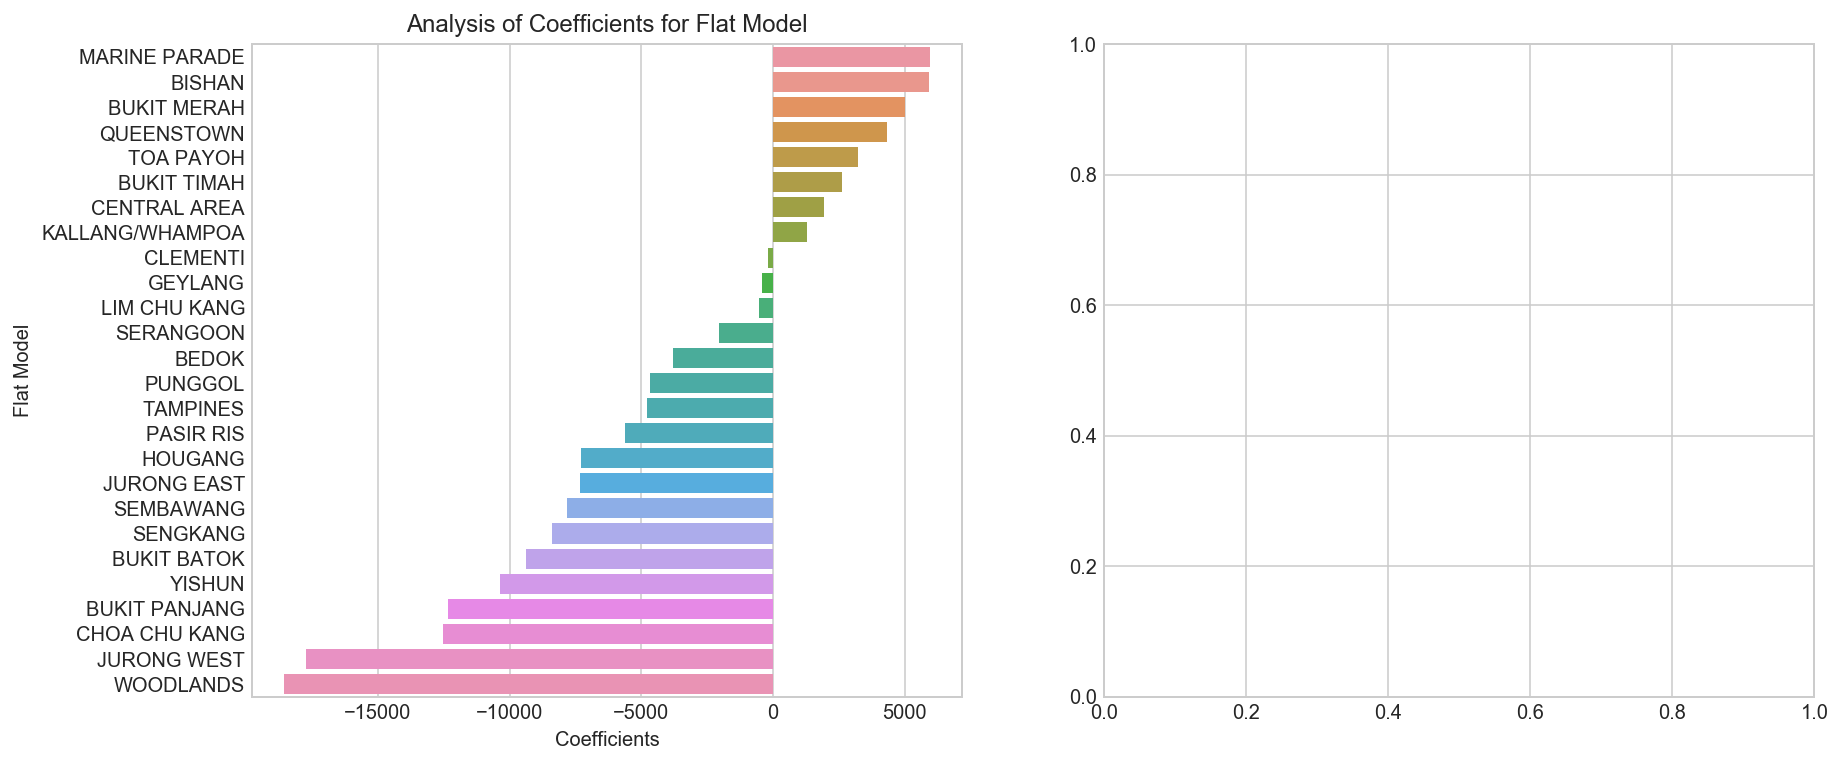

In [41]:
linreg = LinearRegression()
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('linreg',linreg)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3b_basic linreg',summary_model,summary)
coeff = Obtain_coefficients(linreg,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

<a id='3bregularization'></a>
#### Iteration 3b: Ridge, Lasso, enet

Mean of scores: 0.832828136117 | Std of scores: 0.0705578830457
Test score: 0.722605491093
54 out of 56 features are selected.
Coefficients not used: ['flat_model_DBSS', 'flat_model_TYPE S']
        abs_coef          coef                    variable
15  62064.723662  62064.723662            flat_type_5 ROOM
16  48391.658048  48391.658048         flat_type_EXECUTIVE
14  47815.146543  47815.146543            flat_type_4 ROOM
54  38189.375359  38189.375359              floor_area_sqm
13  27719.681386  27719.681386            flat_type_3 ROOM
49  18557.351769 -18557.351769              town_WOODLANDS
37  17730.157411 -17730.157411            town_JURONG WEST
53  13166.892629  13166.892629  calculated_remaining_lease
32  12527.286940 -12527.286940          town_CHOA CHU KANG
29  12349.100701 -12349.100701          town_BUKIT PANJANG


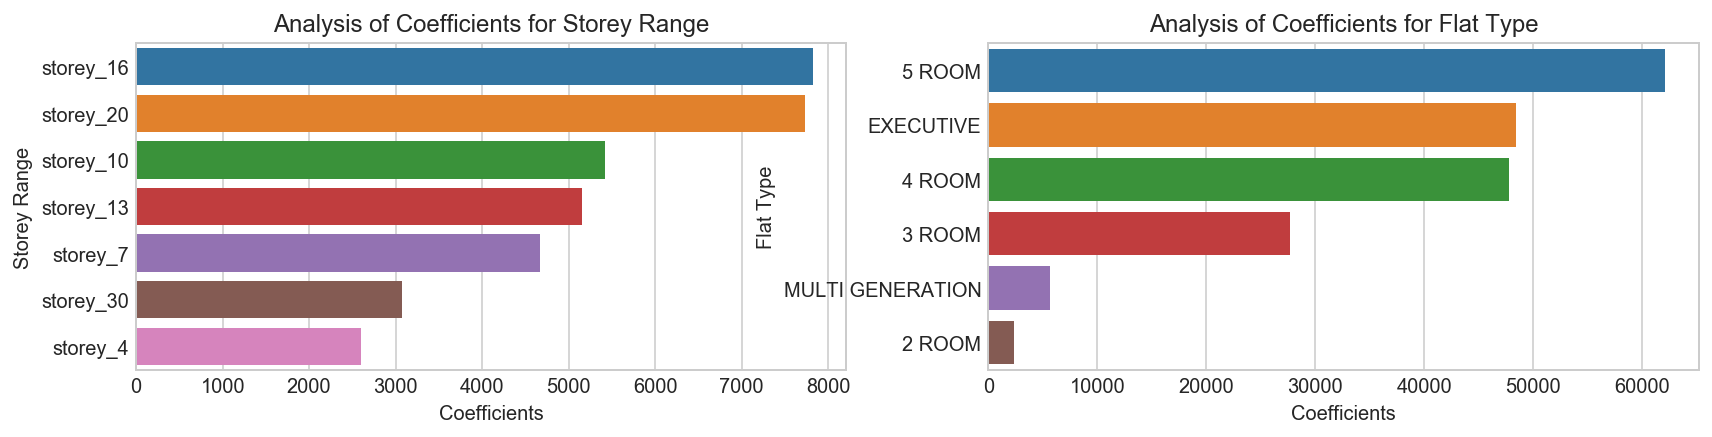

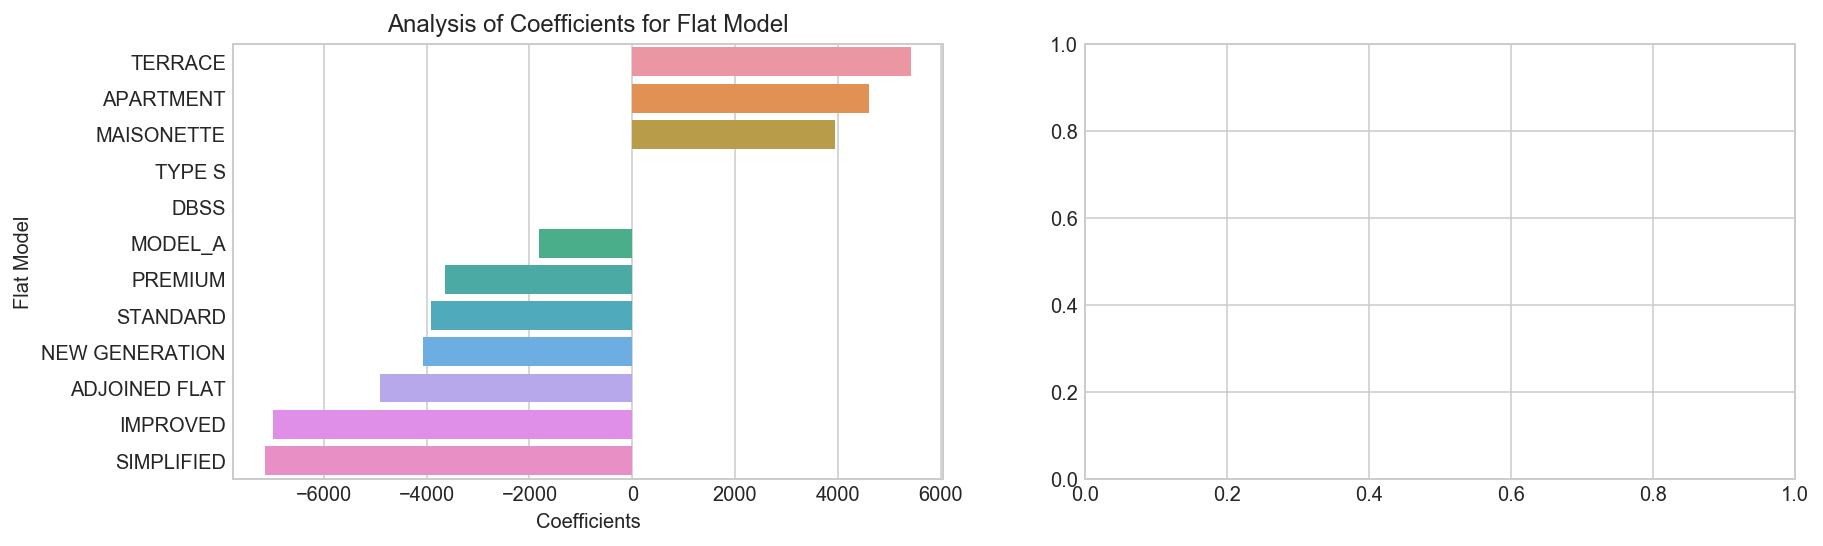

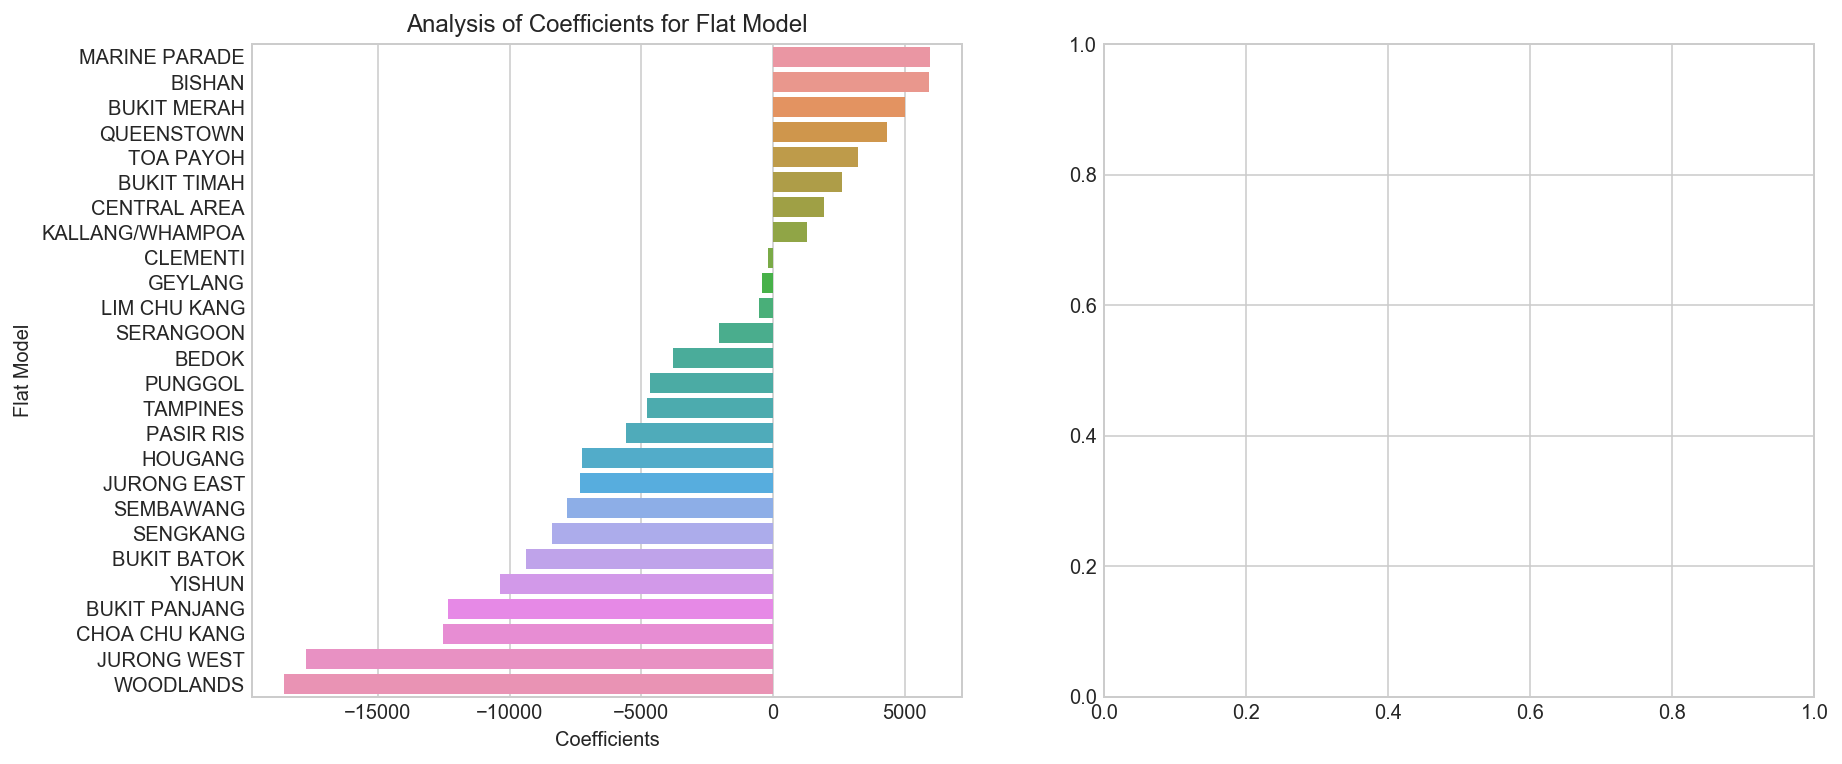

In [42]:
ridge = Ridge()
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('ridge',ridge)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3b_basic ridge',summary_model,summary)
coeff = Obtain_coefficients(ridge,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Mean of scores: 0.832598075655 | Std of scores: 0.068963171098
Test score: 0.717068140797
51 out of 56 features are selected.
Coefficients not used: ['flat_model_DBSS', 'flat_model_NEW GENERATION', 'flat_model_TYPE S', 'flat_type_3 ROOM', 'longitude']
        abs_coef          coef                    variable
54  44566.010746  44566.010746              floor_area_sqm
15  32930.506247  32930.506247            flat_type_5 ROOM
16  30251.995259  30251.995259         flat_type_EXECUTIVE
49  16697.034614 -16697.034614              town_WOODLANDS
14  16536.462170  16536.462170            flat_type_4 ROOM
37  15963.038135 -15963.038135            town_JURONG WEST
53  12989.260216  12989.260216  calculated_remaining_lease
29  11180.133932 -11180.133932          town_BUKIT PANJANG
32  11147.460503 -11147.460503          town_CHOA CHU KANG
50   8728.505041  -8728.505041                 town_YISHUN


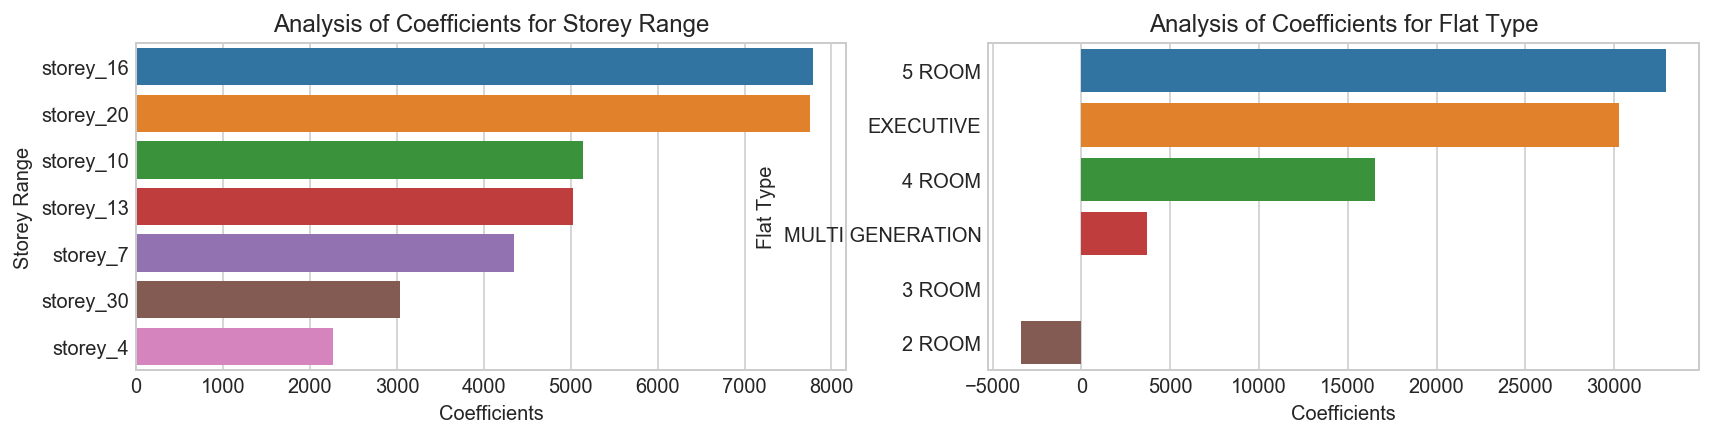

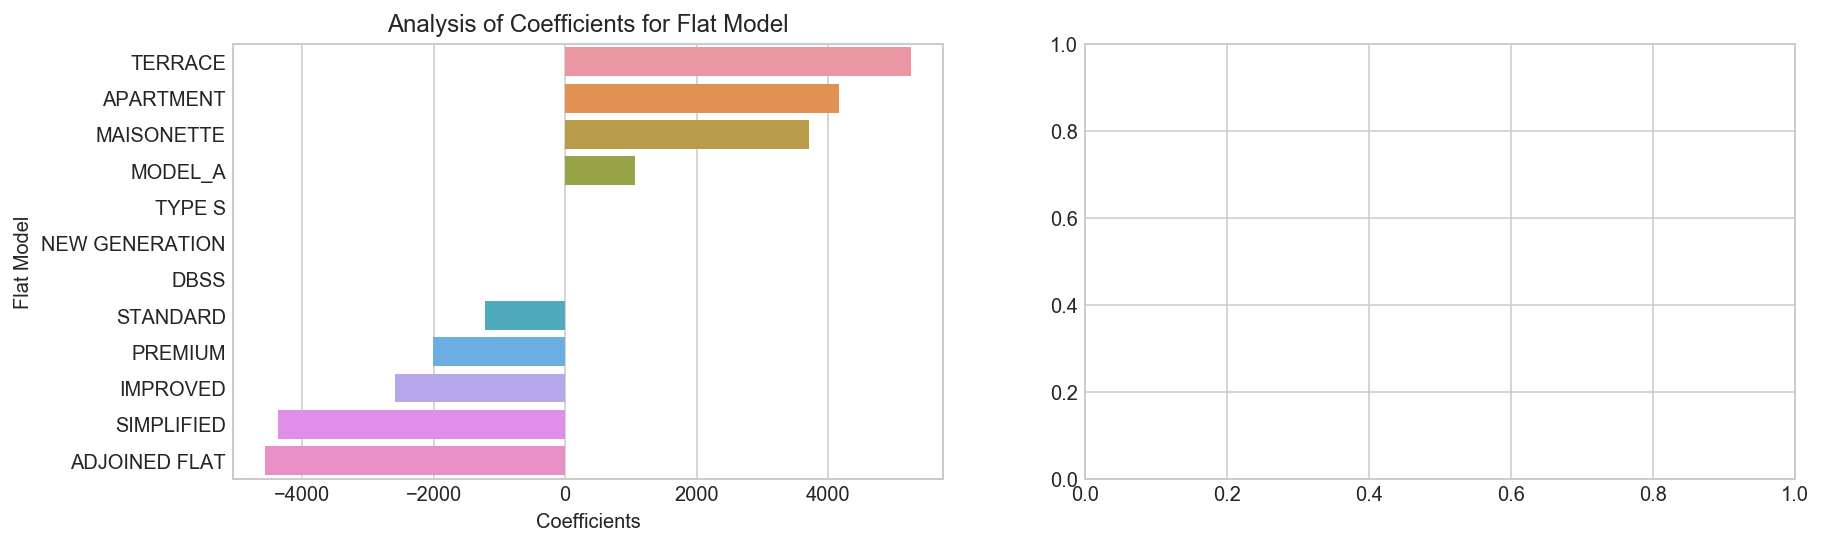

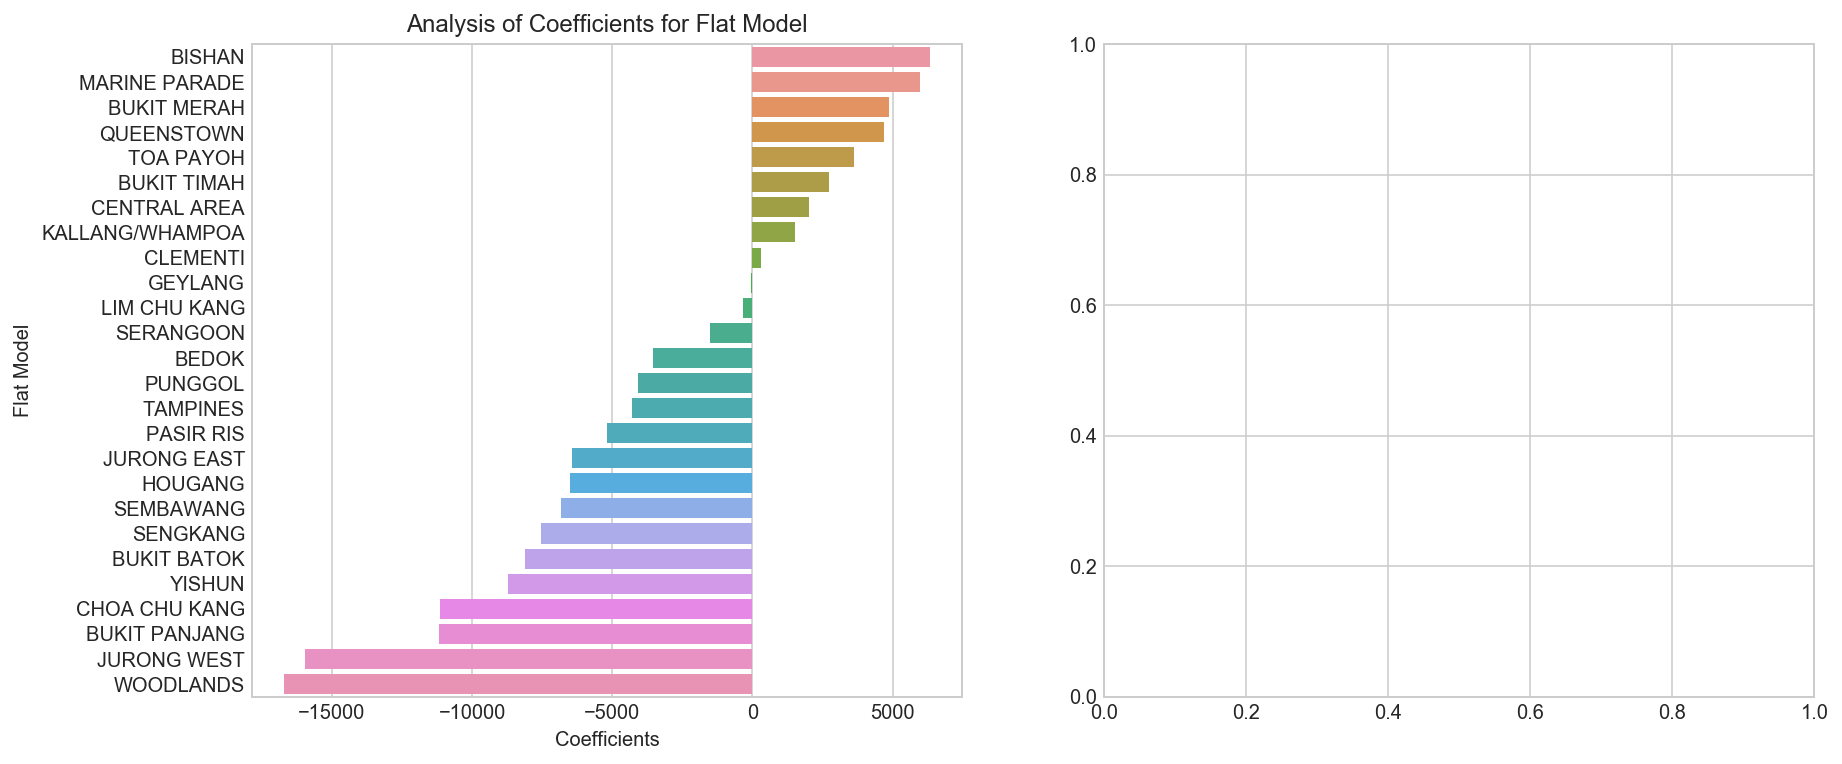

In [43]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(ss.fit_transform(X_train),y_train)
lasso = Lasso(alpha=optimal_lasso.alpha_)
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('lasso',lasso)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3b_basic lasso',summary_model,summary)
coeff = Obtain_coefficients(lasso,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Mean of scores: 0.832598075655 | Std of scores: 0.068963171098
Test score: 0.717068140797
51 out of 56 features are selected.
Coefficients not used: ['flat_model_DBSS', 'flat_model_NEW GENERATION', 'flat_model_TYPE S', 'flat_type_3 ROOM', 'longitude']
        abs_coef          coef                    variable
54  44566.010746  44566.010746              floor_area_sqm
15  32930.506247  32930.506247            flat_type_5 ROOM
16  30251.995259  30251.995259         flat_type_EXECUTIVE
49  16697.034614 -16697.034614              town_WOODLANDS
14  16536.462170  16536.462170            flat_type_4 ROOM
37  15963.038135 -15963.038135            town_JURONG WEST
53  12989.260216  12989.260216  calculated_remaining_lease
29  11180.133932 -11180.133932          town_BUKIT PANJANG
32  11147.460503 -11147.460503          town_CHOA CHU KANG
50   8728.505041  -8728.505041                 town_YISHUN


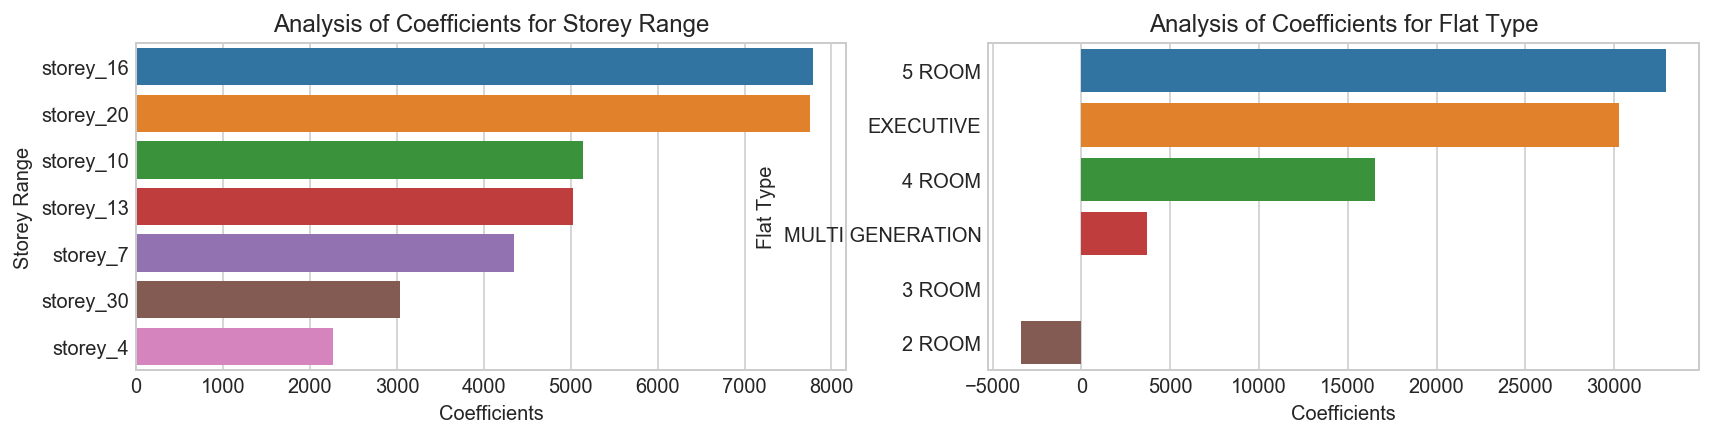

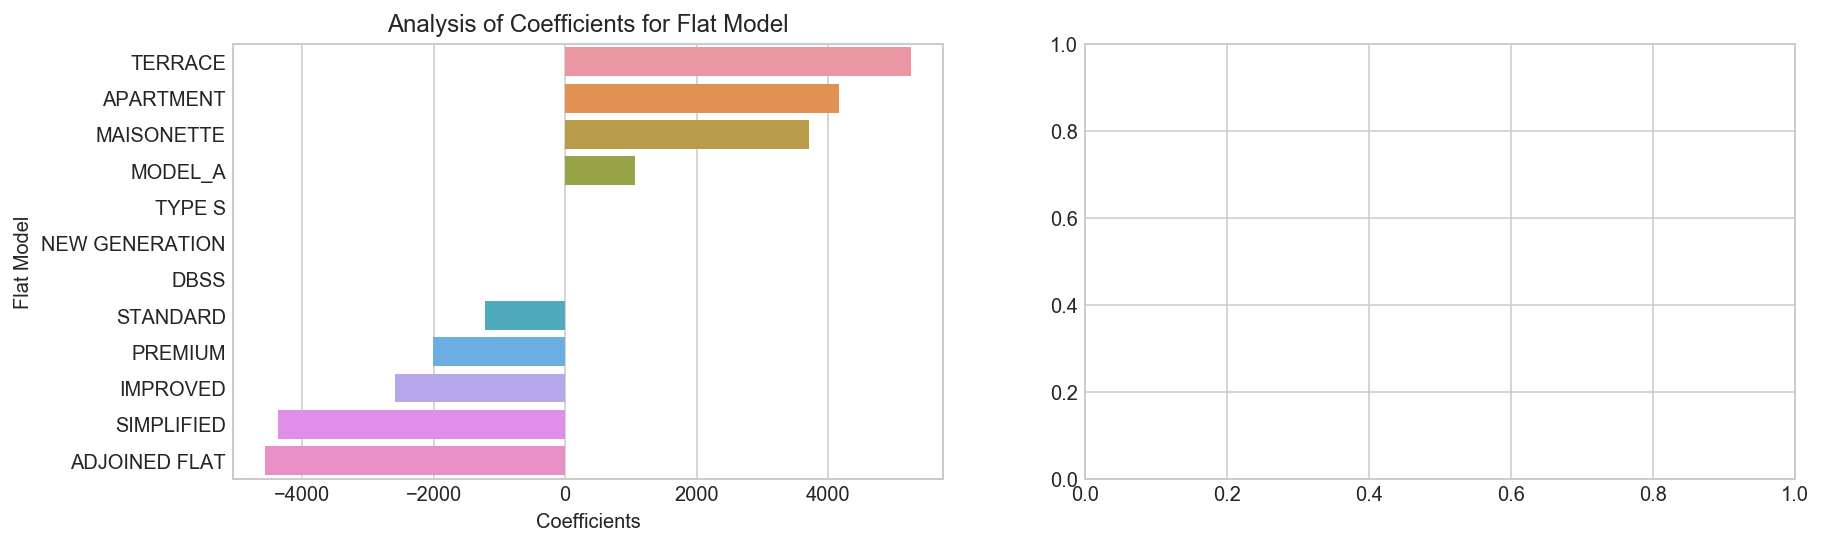

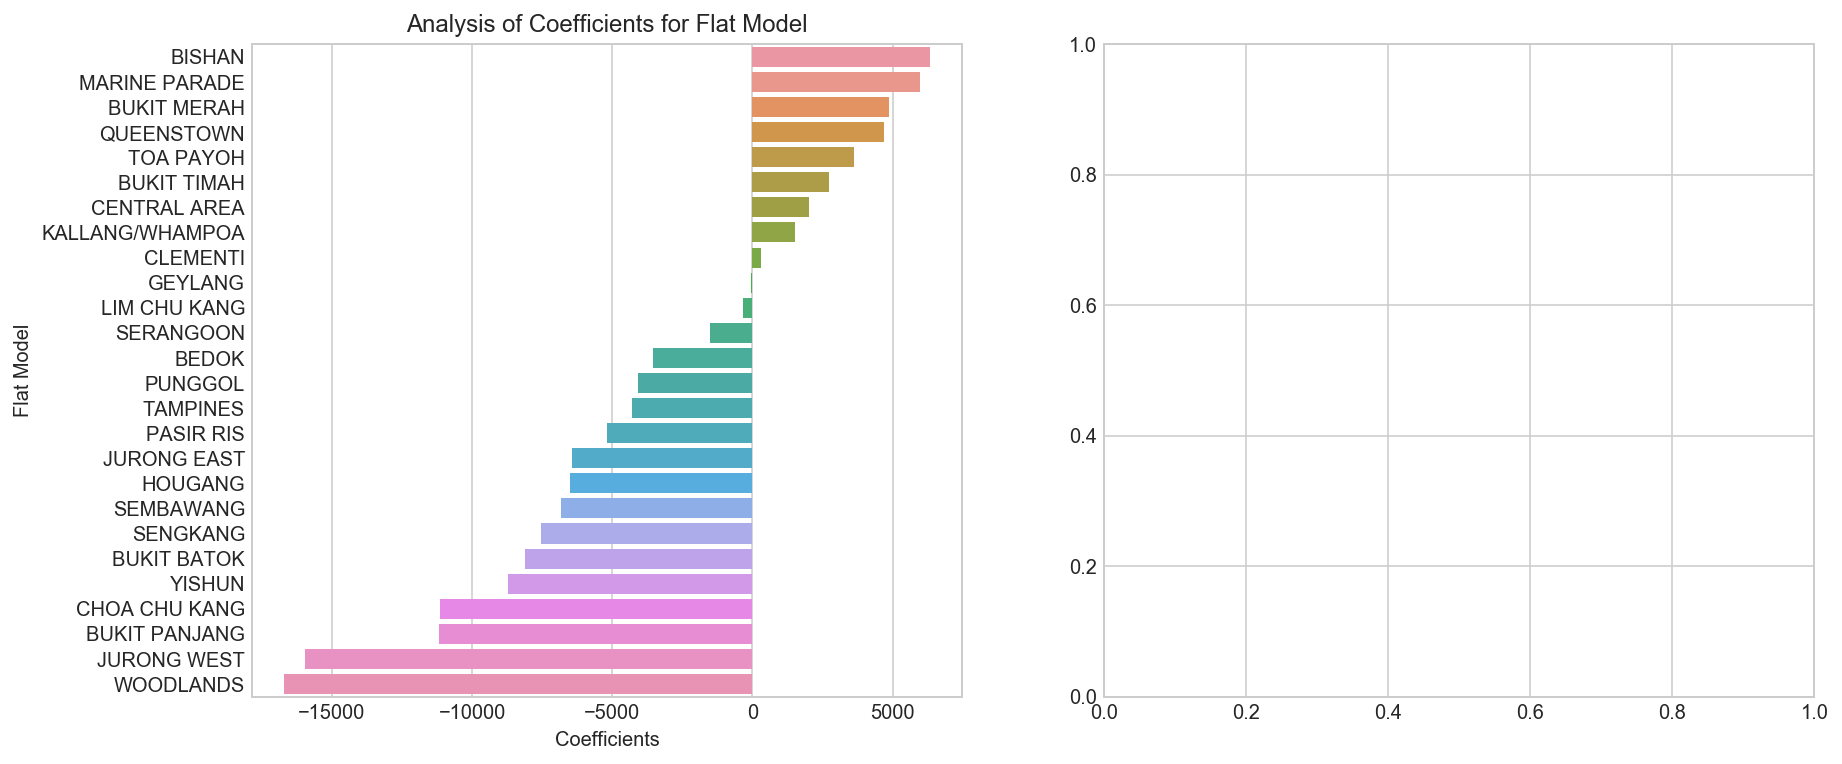

In [44]:
l1_ratios = np.linspace(0.01, 1.0, 25)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=30, cv=10,
                            verbose=1)
optimal_enet.fit(ss.fit_transform(X_train),y_train)
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
pipe = Pipeline(steps=[('standard scaler', ss),
                       ('enet',enet)])
pipe.fit(X_train,y_train)

summary_model = Obtain_summary(pipe,X_train, y_train, X_test, y_test)
summary = Add_model('iter3b_basic enet',summary_model,summary)
coeff = Obtain_coefficients(enet,ss.fit_transform(X_train),y_train,X)
Analyse_coef(coeff,X)

##### Insights 

In [45]:
summary.sort_values('test_score',ascending = False)

,model,train_mean_score,train_std_score,test_score
0,iter3b_basic ridge,0.832828,0.0705579,0.722605
0,iter3a_basic ridge,0.832779,0.0702241,0.722604
0,iter3b_basic lasso,0.832598,0.0689632,0.717068
0,iter3b_basic enet,0.832598,0.0689632,0.717068
0,iter3a_basic lasso,0.832554,0.0687135,0.717052
0,iter3a_basic enet,0.832554,0.0687135,0.717052
0,iter3b_basic linreg,0.832833,0.0705592,-1.0083e+17
0,iter3b_basic linreg,0.832833,0.0705592,-1.0083e+17
0,iter3a_basic linreg,0.832777,0.0702274,-1.51138e+20


At this point, 
> - my laptop has started to overheat 
> - results from part3 round 1d is better than this results. 
> - it is computationally faster to just use a samller data set 
> - the difference between train and test set is smaller for the smaller data set. due to smaller variance

Therefore, it was decided to not complete running this until I change a better laptop. 

<a id='iter4a'></a>
### Iteration 4a

<a id='4amlrall'></a>
#### Iteration 4a: Multiple variable Linear regression: ALL 

<a id='4aregularization'></a>
#### Iteration 4a: Ridge, Lasso, enet 

<a id='iter4b'></a>
### Iteration 4b

<a id='4bmlrall'></a>
#### Iteration 4b: Multiple variable Linear regression: ALL 

<a id='4bregularization'></a>
#### Iteration 4b: Ridge, Lasso, enet

## Insights